# Enhancing Robustness in EEG Seizure Detection with Topological Feature Representations and Supervised Learning

## INITIALIZATION

### Setting up directories

In [1]:
print("hello")


hello


In [1]:
import sys
print("Python Executable:", sys.executable)
print("\nUser site-packages:", sys.path)


Python Executable: /home/ab/miniconda3/envs/seizure_env/bin/python

User site-packages: ['/home/ab/miniconda3/envs/seizure_env/lib/python311.zip', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11/lib-dynload', '', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages']


In [3]:
import os
import sys 
sys.path.append("../src")
# Create a directory to save the models

os.makedirs('models', 
exist_ok=True)
# Create a directory to save the metrics
os.makedirs('metrics', exist_ok=True)
# Create a directory to save the images
os.makedirs('images', exist_ok=True)


def folder_size(path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

size_bytes = folder_size('models')
size_mb = size_bytes / (1024 * 1024)
print(f"Size of results folder: {size_mb:.2f} MB")


Size of results folder: 0.00 MB


Size of results folder: 0.00 MB


### Loading required packages

In [4]:
# Common utility libraries
import time
import random
import joblib
import itertools
import warnings
import glob, re
from collections import Counter

# Common data science libraries
import numpy as np 
import pandas as pd
import scipy as sp 

# Common visualisations libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm # Color map
import matplotlib.colors as colors 

# Feature Extraction libraries
import pywt
from sklearn.model_selection import train_test_split

# TDA libraries
import persim
from persim import PersistenceImager

from ripser import ripser

import gudhi
from gudhi import bottleneck_distance
from gudhi.wasserstein import wasserstein_distance


import networkx as nx # For drawing the network diagram of distances

from visualization import plot_class_signals, plot_class_distribution, plot_persistence_images, plot_confusion_matrix, plot_persistence_diagrams_from_data
from preprocessing import normalize_data, map_class_labels, artifact_noise
from feature_engineering import FeatureExtractor, extract_fft_features, extract_wavelet_features, get_wavelet_features, get_tda_features_and_labels, get_features_and_labels, get_extractors_methods, gaussian_noise
from ml_pipeline import get_train_test_data, generate_classification_report, train_and_tune_model, split_and_flatten_persistence_images
from run_experiments import run_logistic_regression, run_ridge_classifier, run_knn_classifier, run_sgd_classifier, run_random_forest_classifier, run_mlp_classifier, run_xgboost_classifier, run_svc_classifier, run_catboost_classifier, run_model_on_features, run_model_fft_xgboost, run_model_base_dwt_tda_xgboost
from tda_distances import compute_persistence_diagrams_from_dataframe, bottleneck, bottleneck_between_class, bottleneck_within_class, bottleneck_distance

# Set global variables
%matplotlib inline
## Temporarily comment out the following line (this global pimager definition). The actual PersistenceImager should be instantiated and 
## configured within the new TDA feature generation function, after you have a sense of the typical birth/death ranges of diagrams from 
## your new Takens' embedding approach.
# pimager = PersistenceImager(pixel_size=0.2)

warnings.filterwarnings("ignore", category=RuntimeWarning)
mpl.rcParams['text.usetex'] = False


# Setting the random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# check if TDA packages are working
print("GUDHI:",gudhi.__version__)
print("persim:",persim.__version__)


GUDHI: 3.10.1
persim: 0.3.8


### Reading in the raw data

We have downloaded the NPY files from https://data.mendeley.com/datasets/5pc2j46cbc/1

These are the files x_test.npy, x_train.npy, y_test.npy, y_train.npy. These files were obtained by preprocessing the raw EDF files (also provided in the dataset) using preprocessing.py (https://data.mendeley.com/datasets/5pc2j46cbc/1/files/56ef90d9-04bb-4d02-bff8-7472cc1e8cbb)

The following code takes EEG data stored as 3D NumPy arrays and converts them into CSV files suitable for machine learning, applying two key preprocessing steps along the way.

The X Input Data Structure (from the npy files) is a 3D NumPy array with shape (segments, channels, samples). Each segment represents a time window (like your 1-second windows). Each channel represents an EEG electrode/channel, Each sample represents a time point (500 samples in your case)

The Y data is/are 1D NumPy array/s with labels for each segment

Key Processing Steps
1. Data Reshaping: The code "flattens" the 3D structure by treating each channel of each segment as a separate univariate time series. So if you have 10 segments with 19 channels each, you get 190 individual time series rows in the CSV. Although EEG channels capture signals from different scalp regions (e.g., frontal, temporal, occipital), each with unique noise profiles and physiological artifacts, we can treat the 19 channels as individual time series with the same dynamical properties (like signal complexity and nonlinearity) since these are consistent across channels for the same subject/task due to shared neural generators and volume conduction. Preprocessing parameters can be global because biological noise (e.g., muscle artifacts, eye blinks) affects all channels similarly, while seizures manifest as synchronized bursts across multiple channels, preserving embedding topology.
2. Label Conversion: Converts multi-class labels (0, 1, 2, 3, etc.) into binary labels (0 for non-seizure, 1 for seizure), where anything that wasn't originally 0 becomes 1.
3. Baseline Correction: Subtracts the mean from each time series to center it around zero. The purpose is to remove any remaining DC offset or very slow drift within the 1-second epoch. This "zeros" the data.
4. Per-Segment Z-score Normalization: Standardizes each time series to have mean=0 and standard deviation=1. The purpose is to ensure each 1-second segment has a similar dynamic range or distribution. This is crucial for many ML algorithms and feature extraction methods that are sensitive to feature scales (e.g., TDA persistence image generation if it involves distance calculations, KNN). This step effectively standardizes each 1-second window independently. The script that transformed the raw EDF data intoNPY files did group-wise max-abs scaling. When you combine these groups, the absolute values might still differ significantly. Scaling each 1-second segment individually ensures they are all on a comparable footing before feature extraction.

The following list gives reasons why Baseline Correction (mean subtraction) is often recommended as a separate step even if Z-score Normalization is done after:
1. Conceptual Clarity & Order of Operations: The idea is often to first remove any overall offset (center the signal around zero) to represent pure AC fluctuations. Also, denoising algorithms (like the wavelet denoising I suggested) might behave more predictably or effectively on data that is already zero-mean as the characteristics of noise might be more easily separable from a signal that doesn't have a large DC component. Lastly, normalization/scaling is then applied to the cleaned, centered signal to bring different epochs/channels to a comparable dynamic range for the ML model.
2. Interpretation of Features (if extracted before final scaling):
If you were to extract certain features (e.g., variance, power) from the signal after baseline correction but before Z-score scaling, these features would be calculated on zero-mean data. Power, for example, is directly affected by a DC offset. Removing the offset ensures you're calculating the power of the fluctuations. While Z-scoring also removes the mean, if features are extracted at an intermediate stage, the initial baseline correction is beneficial.
3. Historical Practice & Robustness:
Baseline correction is a very standard step in EEG processing, especially for Event-Related Potentials (ERPs), where a pre-stimulus baseline is used. For continuous data segmented into epochs, subtracting the epoch's own mean is the analogous step. It's often done as a foundational "hygiene" step.
4. Flexibility in Normalization Choice:
If you perform baseline correction (mean subtraction) first, you have a centered signal. You can then decide to apply Z-score, Min-Max, or another scaling method without worrying about the centering aspect again.

Output Format
Creates CSV files with this column structure:

Unnamed: Segment identifier (e.g., "Train_Seg0_Ch0")

X1, X2, ..., X500: The 500 time series sample values (preprocessed)

y: Binary label (0 or 1)



In [6]:
#import numpy as np
#import os
import csv

def create_separate_processed_csvs(x_data_path, y_data_path, set_prefix, output_csv_path):
    """
    Processes a single dataset (.npy files for x and y), applies baseline correction
    and per-segment Z-score normalization, and then creates a CSV file.
    The CSV format is: 'Unnamed' for segment ID, 'X1', 'X2', ... for samples,
    and 'y' for the label.

    Args:
        x_data_path (str): Path to the x_data.npy file.
        y_data_path (str): Path to the y_data.npy file.
        set_prefix (str): Prefix for segment IDs (e.g., "Train" or "Test").
        output_csv_path (str): Path for the output CSV file for this specific set.
    """
    print(f"\nStarting CSV creation for {set_prefix} set. Output will be: {output_csv_path}")
    print(f"  Applying: 1. Baseline Correction (mean subtraction), 2. Per-Segment Z-score Normalization")

    # --- Step 1: Load Data ---
    try:
        x_data = np.load(x_data_path)
        y_labels_original = np.load(y_data_path)
        print(f"  Loaded {x_data_path}, shape: {x_data.shape}")
        print(f"  Loaded {y_data_path}, shape: {y_labels_original.shape}")
    except FileNotFoundError:
        print(f"  Error: Could not find {x_data_path} or {y_data_path}. Skipping CSV creation for this set.")
        return

    # --- Step 2: Validate Data Dimensions ---
    if x_data.ndim != 3:
        print(f"  Error: {x_data_path} is not a 3D array as expected. Shape is {x_data.shape}. Skipping.")
        return
    if y_labels_original.ndim != 1:
        print(f"  Error: {y_data_path} is not a 1D array as expected. Shape is {y_labels_original.shape}. Skipping.")
        return
    if x_data.shape[0] != y_labels_original.shape[0]:
        print(f"  Error: Number of segments in {x_data_path} ({x_data.shape[0]}) "
              f"does not match labels in {y_data_path} ({y_labels_original.shape[0]}). Skipping.")
        return

    # --- Step 3: Determine Header ---
    num_samples_per_series = x_data.shape[2]
    header = ['Unnamed'] + [f'X{i+1}' for i in range(num_samples_per_series)] + ['y']

    # --- Step 4: Open CSV file for writing ---
    with open(output_csv_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(header) # Write header
        print(f"  CSV Header written: 'Unnamed', X1...X{num_samples_per_series}, 'y'.")

        # --- Step 5: Convert Labels and Process Data ---
        y_labels_binary = np.where(y_labels_original == 0, 0, 1)
        print(f"  Converted labels to binary. Unique binary labels: {np.unique(y_labels_binary)}")

        num_segments = x_data.shape[0]
        num_channels = x_data.shape[1]

        for seg_idx in range(num_segments):
            current_segment_label = y_labels_binary[seg_idx]
            for chan_idx in range(num_channels):
                segment_id = f"{set_prefix}_Seg{seg_idx}_Ch{chan_idx}"
                univariate_series_original = x_data[seg_idx, chan_idx, :]

                # --- Preprocessing Steps ---
                # 1. Baseline Correction: Subtract the mean
                mean_val = np.mean(univariate_series_original)
                baseline_corrected_series = univariate_series_original - mean_val

                # 2. Per-Segment Normalization: Apply Z-score scaling
                std_dev = np.std(baseline_corrected_series)
                if std_dev == 0: # Avoid division by zero for flat signals (all values are the same after mean subtraction)
                    # If std_dev is 0, the signal is constant (all zeros after baseline correction).
                    # Z-score would be NaN or Inf. We can keep it as all zeros.
                    processed_series = baseline_corrected_series
                else:
                    processed_series = (baseline_corrected_series - np.mean(baseline_corrected_series)) / std_dev
                    # Note: np.mean(baseline_corrected_series) should be very close to 0,
                    # so this is effectively baseline_corrected_series / std_dev

                # Row: Segment ID, X1, X2, ..., XN, label
                row_to_write = [segment_id] + list(processed_series) + [current_segment_label]
                csv_writer.writerow(row_to_write)

            if (seg_idx + 1) % 100 == 0 or (seg_idx + 1) == num_segments: # Progress update
                print(f"    Processed {seg_idx + 1}/{num_segments} segments from {set_prefix} set...")
        print(f"  Finished processing {set_prefix} data. Wrote {num_segments * num_channels} univariate series rows to {output_csv_path}")


In [7]:
# Configuration and execution
base_data_dir = "./npy_files"

# File paths
paths = {
    'train': {
        'x': os.path.join(base_data_dir, "x_train.npy"),
        'y': os.path.join(base_data_dir, "y_train.npy"),
        'output': "./train_data_processed_preexisting_format.csv"
    },
    'test': {
        'x': os.path.join(base_data_dir, "x_test.npy"),
        'y': os.path.join(base_data_dir, "y_test.npy"),
        'output': "./test_data_processed_preexisting_format.csv"
    }
}

# Execute processing
for dataset_name, dataset_paths in paths.items():
    create_separate_processed_csvs(
        dataset_paths['x'], 
        dataset_paths['y'], 
        dataset_name.capitalize(), 
        dataset_paths['output']
    )

print("All processed CSV files created successfully.")


Starting CSV creation for Train set. Output will be: ./train_data_processed_preexisting_format.csv
  Applying: 1. Baseline Correction (mean subtraction), 2. Per-Segment Z-score Normalization
  Error: Could not find ./npy_files/x_train.npy or ./npy_files/y_train.npy. Skipping CSV creation for this set.

Starting CSV creation for Test set. Output will be: ./test_data_processed_preexisting_format.csv
  Applying: 1. Baseline Correction (mean subtraction), 2. Per-Segment Z-score Normalization
  Error: Could not find ./npy_files/x_test.npy or ./npy_files/y_test.npy. Skipping CSV creation for this set.
All processed CSV files created successfully.


In [5]:
import pandas as pd # Ensure pandas is imported if this is the first pandas call in a new script/session

# Load train_data_processed_preexisting_format.csv and call the DataFrame df_train_full.
# The test data will be loaded later when needed for evaluation.
try:
    df_train_full = pd.read_csv("train_data_processed_preexisting_format.csv") # ADJUST PATH AS NEEDED
    print("Successfully loaded train_data_processed_preexisting_format.csv")
    print("Shape of df_train_full:", df_train_full.shape)
except FileNotFoundError:
    print("ERROR: train_data_processed_preexisting_format.csv not found. Please check the path.")
    # Optionally, raise an error or exit if the file is critical for subsequent steps
    # raise

# Assuming your label column is 'y'.
target = 'y'

# Define predictor columns
# This should work for your new CSV (Unnamed, X1...X500, y). Verify by printing.
if 'df_train_full' in locals(): # Check if df_train_full was loaded
    # The first column is 'Unnamed', so data.columns.to_list()[1:] starts from 'X1'
    # and goes up to 'y'. Then 'y' is removed.
    predictors = df_train_full.columns.to_list()[1:] 
    if target in predictors:
        predictors.remove(target)
    else:
        print(f"Warning: Target column '{target}' not found in initial predictor list derived from columns [1:].")
        # Fallback or error handling might be needed if target isn't last or structure is unexpected.
        # For now, assuming 'X1' to 'X500' are correctly captured.
        # A more robust way if X columns are always named Xn:
        # predictors = [col for col in df_train_full.columns if col.startswith('X')]

    print(f"\nFirst 5 predictor columns: {predictors[:5]}")
    print(f"Last 5 predictor columns: {predictors[-5:]}")
    print(f"Total number of predictors: {len(predictors)}") # Should be 500

    print("\nHead of df_train_full:")
    print(df_train_full.head())
else:
    print("Skipping predictor definition as df_train_full was not loaded.")

# Placeholder for test data loading - this will be done later, before evaluation.
# df_test_full = None 
# try:
#     df_test_full = pd.read_csv("./test_data_processed_preexisting_format.csv") # ADJUST PATH AS NEEDED
#     print("\nSuccessfully loaded test_data_processed_preexisting_format.csv")
#     print("Shape of df_test_full:", df_test_full.shape)
# except FileNotFoundError:
#     print("ERROR: test_data_processed_preexisting_format.csv not found. Will attempt to load later if needed.")


Successfully loaded train_data_processed_preexisting_format.csv
Shape of df_train_full: (133209, 502)

First 5 predictor columns: ['X1', 'X2', 'X3', 'X4', 'X5']
Last 5 predictor columns: ['X496', 'X497', 'X498', 'X499', 'X500']
Total number of predictors: 500

Head of df_train_full:
          Unnamed        X1        X2        X3        X4        X5        X6  \
0  Train_Seg0_Ch0  0.016913  0.011354  0.015523  0.041928  0.093348  0.160055   
1  Train_Seg0_Ch1  1.147706  1.100758  1.070061  1.073673  1.124232  1.207294   
2  Train_Seg0_Ch2 -0.159233 -0.166152 -0.168458 -0.161539 -0.147701 -0.132710   
3  Train_Seg0_Ch3 -0.419138 -0.395264 -0.371391 -0.349506 -0.327622 -0.303749   
4  Train_Seg0_Ch4  0.305178  0.300836  0.313860  0.339908  0.392004  0.452783   

         X7        X8        X9  ...      X492      X493      X494      X495  \
0  0.223983  0.275402  0.310146  ...  0.058605  0.158665  0.250387  0.336551   
1  1.295772  1.364389  1.396891  ...  1.427588  1.434810  1.422171  1

Unique labels in df_viz_binary['y'] before mapping: [1 0]
Shape of X_viz_binary for plotting: (133209, 500)
Shape of y_viz_numeric_binary for plotting: (133209,)


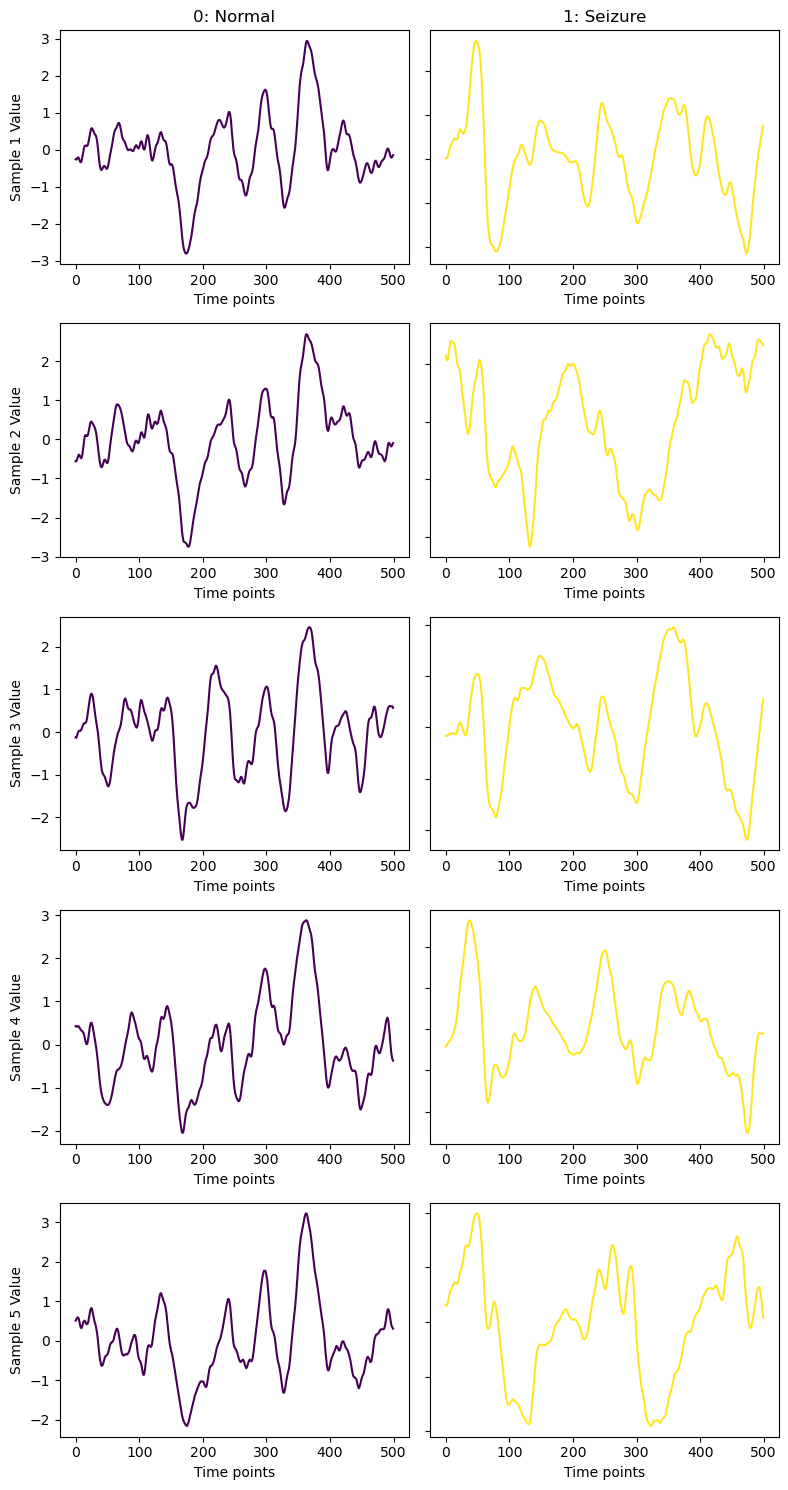

In [6]:
#df_viz = data.copy()
#class_labels = {
#    0: 'no seizure',
#    1: 'seizure activity'
#}
#df_viz['y'] = df_viz['y'].map(class_labels)
#X_viz = normalize_data(df_viz, predictors)  
#y_viz, _ =  get_features_and_labels(data)  

# Assuming df_train_full and predictors are defined from the previous modified cell
# And CLASS_LABELS will be defined later (or use a new binary one here)

if 'df_train_full' in locals():
    df_viz_binary = df_train_full.copy() # Use the new training data

    # Define class labels for your binary task
    class_labels_binary = {
        0: 'Normal',    # Assuming 0 is Normal in your new 'y' column
        1: 'Seizure'    # Assuming 1 is Seizure in your new 'y' column
    }
    # Check unique values in 'y' to confirm they are 0 and 1
    print(f"Unique labels in df_viz_binary['y'] before mapping: {df_viz_binary['y'].unique()}")

    # Map numeric 'y' to string labels in the copy for visualization titles
    # Ensure that the keys in class_labels_binary match the actual numeric labels in df_viz_binary['y']
    df_viz_binary['y_str'] = df_viz_binary['y'].map(class_labels_binary) 
    
    # Handle X_viz normalization ===
    # Your CSV data is already per-segment Z-score normalized.
    # Option 1: Use data as-is for visualization (recommended to see true preprocessed state)
    X_viz_binary = df_viz_binary[predictors] 
    # Option 2: Apply the notebook's original row-wise MinMax for visualization comparison (uncomment if desired)
    # X_viz_binary = normalize_data(df_viz_binary, predictors) # normalize_data is from preprocessing.py

    # Get y_viz (numeric labels) ===
    # y_viz_binary will be the numeric labels (0 or 1)
    # The original get_features_and_labels also did scaling, which we might not want if X_viz_binary is already set.
    # Simpler to just take the 'y' column directly.
    y_viz_numeric_binary = df_viz_binary['y'].values # Get the numeric 0/1 labels

    print(f"Shape of X_viz_binary for plotting: {X_viz_binary.shape}")
    print(f"Shape of y_viz_numeric_binary for plotting: {y_viz_numeric_binary.shape}")
    
    # Call modified plot_class_signals ===
    # The plot_class_signals function itself will need to handle 2 classes and potentially the class_labels_binary dict
    # Let's assume the modified plot_class_signals can take the class_labels dict and infers n_classes, or we pass n_classes.
    
    # from visualization import plot_class_signals # Assuming it's imported
    plot_class_signals(
        X_viz_binary, 
        y_viz_numeric_binary, 
        class_labels_map=class_labels_binary, # Pass the label map
        samples_per_class=5 # Or a different number appropriate for 2 classes
    )
else:
    print("df_train_full not loaded. Skipping visualization cell [5] modifications.")

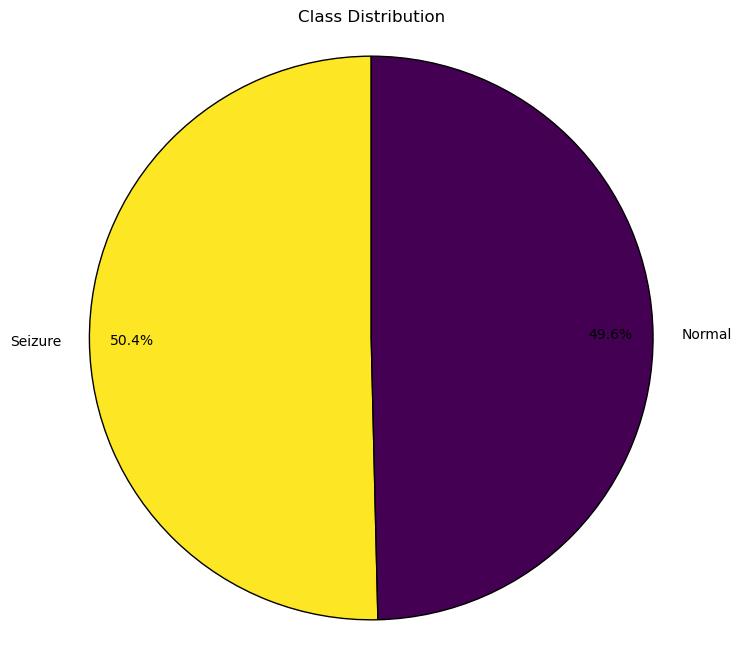

In [7]:
#plot_class_signals(X_viz, y_viz)

# Call modified plot_class_distribution ===
if 'df_viz_binary' in locals():
    # The plot_class_distribution function will need modification (see below)
    # It should use the 'y_str' column for labels if we created it,
    # or be able to handle numeric 'y' and use the class_labels_binary map.
    # Let's assume we pass the DataFrame and the column with string labels.
    
    # from visualization import plot_class_distribution # Assuming it's imported
    plot_class_distribution(
        df_viz_binary, 
        label_column='y_str', # Use the column with string labels 'Normal', 'Seizure'
        class_labels_map=class_labels_binary # Pass the label map for consistent colors/ordering if needed
    ) 
else:
    print("df_viz_binary not created. Skipping visualization cell [6] modifications.")

#### Compute Takens Parameters

In [8]:
# Segment_Name   X1      X2      ...   X500   Label
# Train_Seg0_Ch0 0.123   0.456   ...   0.789  0
# Train_Seg0_Ch1 0.234   0.567   ...   0.890  0
# Test_Seg4_Ch18 0.345   0.678   ...   0.901  1

# The following code computes the Takens parameters with an input csv file that looks like the above comment

#Step 1: Load Data
import pandas as pd
import numpy as np

df = df_train_full.copy() 
series = df.iloc[:, 1:501].values  # Shape: (n_series, 500)
labels = df["y"].values            # Shape: (n_series,)

#Step 2: Create Balanced Subset
n_per_class = 100  # 100 seizure + 100 non-seizure

# Get indices for each class
class0_idx = np.where(labels == 0)[0]
class1_idx = np.where(labels == 1)[0]

# Randomly select 100 per class
subset_idx = np.concatenate([
    np.random.choice(class0_idx, n_per_class, replace=False),
    np.random.choice(class1_idx, n_per_class, replace=False)
])
subset_series = series[subset_idx]  # Shape: (200, 500)

#Step 3: Compute τ (Time Delay) via Mutual Information

from sklearn.metrics import mutual_info_score

def compute_mutual_info(ts, max_lag=50):
    mis = []
    for lag in range(1, max_lag + 1):
        x1 = ts[:-lag]
        x2 = ts[lag:]
        mi = mutual_info_score(None, None, contingency=np.histogram2d(x1, x2, bins=10)[0])
        mis.append(mi)
    # Find first local minimum
    for i in range(1, len(mis) - 1):
        if mis[i] < mis[i - 1] and mis[i] < mis[i + 1]:
            return i + 1  # τ = lag index
    return 1  # Default if no minimum

# Compute τ for each series in subset
taus = [compute_mutual_info(ts) for ts in subset_series]
global_tau = int(np.median(taus))  # Median τ for all series

print(f"Time Delay (tau) computed using mutual information: {global_tau}")

#Step 4: Compute d (Embedding Dimension) via False Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

def false_nearest_neighbors(ts, tau, d_max=10, rtol=15, R_A=2.0): # Added R_A, a common FNN parameter
    n = len(ts)
    fnn_percentages = []

    # Pre-embed to maximum possible length needed for d_max
    # Max components needed = d_max + 1
    # Max length of embedded vector = (d_max) * tau (since it's (d_max-1)*tau for d_max-1 dim, and then one more tau step)
    # No, it's (d_max)*tau for the d_max dimensional vectors.
    # And (d_max+1-1)*tau = d_max*tau for the (d_max)-th component of (d_max+1) vector
    # Let's stick to your iterative embedding for now and fix the indexing.

    for d in range(1, d_max + 1): # Loop for current dimension 'd'
        # Construct d-dimensional embedding
        # Y_k = (x_k, x_{k+tau}, ..., x_{k+(d-1)tau})
        # Number of such points M = n - (d-1)*tau
        if n <= (d - 1) * tau: # Not enough points for this dimension
            fnn_percentages.append(1.0) # Indicate all are FNN or invalid
            continue
        
        embedding_d = np.array([ts[i : i + (d - 1) * tau + 1 : tau] for i in range(n - (d - 1) * tau)])
        if d == 1: # For d=1, embedding_d is (M, 1), make it (M,) for some FNN versions
            embedding_d = embedding_d.reshape(-1,1) # Ensure it's 2D for NearestNeighbors

        # Find nearest neighbors for each point in d-dimensional space
        # We only need one nearest neighbor (excluding the point itself)
        nn = NearestNeighbors(n_neighbors=2, algorithm='kd_tree')
        nn.fit(embedding_d)
        distances_d, indices_d = nn.kneighbors(embedding_d)

        # distances_d[:,1] are distances to nearest true neighbor
        # indices_d[:,1] are indices of nearest true neighbor (within embedding_d)

        # Now consider the (d+1)-th component
        # We need to check if adding x_{k+d*tau} causes a large jump
        
        num_fnn = 0
        num_valid_comparisons = 0

        for i in range(len(embedding_d)):
            neighbor_idx = indices_d[i, 1] # Index of the nearest neighbor in embedding_d

            # Check if both point i and its neighbor neighbor_idx can be extended to (d+1) dimensions
            # This means their original time series indices must allow for one more component x(t + d*tau)
            # Original time index for embedding_d[i] is 'i'
            # Original time index for embedding_d[neighbor_idx] is 'neighbor_idx'
            
            # The (d+1)-th component for point 'i' would be ts[i + d*tau]
            # The (d+1)-th component for point 'neighbor_idx' would be ts[neighbor_idx + d*tau]
            
            if (i + d * tau < n) and (neighbor_idx + d * tau < n):
                num_valid_comparisons += 1
                
                # Distance in d-dimensions (squared, to avoid sqrt initially)
                # dist_sq_d = np.sum((embedding_d[i] - embedding_d[neighbor_idx])**2)
                # Using the distance already found by NearestNeighbors is better
                dist_d_i_neighbor = distances_d[i, 1]
                if dist_d_i_neighbor == 0: # Avoid division by zero if points are identical
                    continue

                # Calculate distance in (d+1) dimensions
                # This is the squared Euclidean distance of the (d+1)th components,
                # added to the squared d-dimensional distance.
                # Or, more commonly, the ratio of the (d+1)-dim distance to d-dim distance.
                
                # Let's use the Kennel et al. criteria:
                # Criterion 1: R_d(i, tau) = || Y(i+1) - Y_nn(i+1) || / || Y(i) - Y_nn(i) || > R_tol
                # where Y(i) is d-dim, Y(i+1) is (d+1)-dim
                # This requires constructing (d+1) dim vectors and recalculating distances,
                # which is computationally more intensive than the "component-wise" check.
                
                # Your original approach was trying to compare:
                # || vectors_d1[i] - vectors_d1[neighbor_of_i_in_d_dim] || vs || vectors_d[i] - vectors_d[neighbor_of_i_in_d_dim] ||
                # The issue is `vectors_d1` is shorter.

                # Let's try to adapt your structure:
                # We need to compare point i and its d-dim neighbor (neighbor_idx)
                # *after* they are both projected to (d+1) dimensions, IF POSSIBLE.

                # Point i in (d+1) dim: ts[i : i + d*tau + 1 : tau]
                # Point neighbor_idx in (d+1) dim: ts[neighbor_idx : neighbor_idx + d*tau + 1 : tau]
                
                # This check was already done: (i + d * tau < n) and (neighbor_idx + d * tau < n)
                
                vec_i_d1 = ts[i : i + d * tau + 1 : tau]
                vec_neighbor_d1 = ts[neighbor_idx : neighbor_idx + d * tau + 1 : tau]

                dist_d1_i_neighbor = np.linalg.norm(vec_i_d1 - vec_neighbor_d1)

                if (dist_d1_i_neighbor / dist_d_i_neighbor) > rtol:
                    num_fnn += 1
                
                # Second FNN criterion (Kennel et al.): Check if (d+1)-dim distance exceeds overall attractor size
                # R_A is often standard deviation of the original time series.
                # if dist_d1_i_neighbor > R_A * np.std(ts): # This is another heuristic
                #    if not ((dist_d1_i_neighbor / dist_d_i_neighbor) > rtol): # Only count if not already FNN by first rule
                #        num_fnn += 1
                        
            # else: point i or its neighbor cannot be extended to d+1 dimensions, skip.

        if num_valid_comparisons > 0:
            fnn_percentages.append(num_fnn / num_valid_comparisons)
        else:
            fnn_percentages.append(1.0) # No valid comparisons, assume all FNN or d is too large

        # Stop if fraction drops below a threshold (e.g., 5% or 1%)
        if fnn_percentages[-1] < 0.05: # Or some other small threshold
            return d # Current dimension 'd' is good

    # If no dimension clearly drops FNN below threshold, return the one with minimum FNN percentage
    if not fnn_percentages: # Should not happen if d_max >= 1
        return 1 
    min_fnn_idx = np.argmin(fnn_percentages)
    return min_fnn_idx + 1 # Dimensions are 1-indexed

# Compute d for each series using global_tau
d_vals = [false_nearest_neighbors(ts, global_tau) for ts in subset_series]
global_d = int(np.median(d_vals))  # Median d for all series

print(f"Embedding dimension (d) computed using false nearest neighbors: {global_d}")

Time Delay (tau) computed using mutual information: 16
Embedding dimension (d) computed using false nearest neighbors: 3


In [9]:
#df_train = data.copy()
#df_train[predictors] = normalize_data(df_train, predictors)

# Assuming df_train_full and predictors are defined from the modified cell [4]

# Redefine df_train and reconsider initial normalization ===
if 'df_train_full' in locals():
    df_train = df_train_full.copy() # This df_train will be used by feature extractors

    # Your CSV data is already per-segment Z-score normalized.
    # The original notebook's normalize_data (row-wise MinMax) is likely redundant
    # or counterproductive, as subsequent feature engineering steps (like FeatureExtractor.get_baseline
    # or get_features_and_labels within the TDA pipeline) will apply their own column-wise StandardScaler.

    # HENCE remove the initial normalize_data call entirely (RECOMMENDED)
    # Let the StandardScaler in feature_engineering.py be the primary scaler if needed.
    print("df_train created. Initial row-wise MinMax scaling (normalize_data) from original notebook is SKIPPED.")
    print("Subsequent feature engineering steps will use their internal scaling (typically column-wise StandardScaler).")

df_train created. Initial row-wise MinMax scaling (normalize_data) from original notebook is SKIPPED.
Subsequent feature engineering steps will use their internal scaling (typically column-wise StandardScaler).


## Bottleneck distances (H1)

### Note: Here are the class labels

In [10]:
#CLASS_LABELS = {
#    5: 'eyes open',
#    4: 'eyes closed',
#    3: 'tumor region identified',
#    2: 'EEG from tumor area',
#    1: 'seizure activity'
#}

# Update CLASS_LABELS for binary classification ===
# This should be consistent with class_labels_binary defined earlier for visualization,
# and used by any functions that might rely on a global CLASS_LABELS.
CLASS_LABELS = {
    0: 'Normal',    # Assuming 0 is Normal in your 'y' column
    1: 'Seizure'    # Assuming 1 is Seizure in your 'y' column
}
print(f"Global CLASS_LABELS set to: {CLASS_LABELS}")

Global CLASS_LABELS set to: {0: 'Normal', 1: 'Seizure'}


In [11]:
#diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train, maxdim=1)

# RUNNING THIS CELL WILL TAKE LOTS OF TIME AS IT GOES THROUGH EACH TIME SERIES IN df_train

# Call NEW/MODIFIED compute_persistence_diagrams function ===
# The function tda_distances.compute_persistence_diagrams_from_dataframe needs a major rewrite to implement Takens' embedding 
# on individual series. Let's assume you created a new function, e.g., compute_takens_persistence_diagrams.

from tda_distances import compute_takens_persistence_diagrams 

if 'df_train' in locals() and 'predictors' in locals() and 'target' in locals():
    # from tda_distances import compute_takens_persistence_diagrams # This would be your new function
    
    # define Takens' embedding parameters
    takens_embedding_dim = global_d  # we computed this earlier
    takens_time_delay = global_tau   # we computed this earlier
    ripser_max_homology_dim = 1      # Max homology dimension for Ripser (H0, H1 if maxdim=1)

    print(f"Attempting to compute persistence diagrams using Takens' embedding with dim={takens_embedding_dim}, delay={takens_time_delay}...")

    # diagrams_takens stores all the computed persistence diagrams (H0, H1, etc.) for every 
    #    single input univariate time series (row) from your dataframe. You can access the H1 
    #    diagram for the time series at original DataFrame index i using diagrams_takens[i]
    # labels_takens stores the true class label for each univariate time series for which 
    #    diagrams were computed. You can get the label for the time series at original 
    #    DataFrame index i using labels_takens[i]
    # If you want to get the H1 diagram and the label for the first time series processed 
    # (which was at index 0 in df_train), you would use 
    #        h1_diagram_for_series_0 = diagrams_takens
    #        label_for_series_0 = labels_taken
    diagrams_takens, labels_takens = compute_takens_persistence_diagrams(
        dataframe=df_train, 
        predictor_columns=predictors, # Your list of 'X1'...'X500'
        target_column=target,         # Your target column name, e.g., 'y'
        embedding_dim=takens_embedding_dim,
        time_delay=takens_time_delay,
        max_homology_dim=ripser_max_homology_dim
        # You can also pass skip_tde, ripser_coeff, ripser_thresh if you want non-default values
    )
    
    print(f"Computed {len(diagrams_takens)} Takens-based diagram sets.")
    # Example: Inspect the first computed diagram set and its label
    if diagrams_takens:
        first_key = list(diagrams_takens.keys())[0]
        print(f"\nDiagrams for series ID '{first_key}':")
        for dim, dgm_array in diagrams_takens[first_key].items():
            print(f"  H{dim} diagram shape: {dgm_array.shape}")
        print(f"Label for series ID '{first_key}': {labels_takens[first_key]}")
else:
    print("df_train, predictors, or target not defined. Skipping diagram computation.")


Attempting to compute persistence diagrams using Takens' embedding with dim=3, delay=16...
Processing 133209 time series for Takens' embedding and Ripser...
  Processed 100/133209 series...
  Processed 200/133209 series...
  Processed 300/133209 series...
  Processed 400/133209 series...
  Processed 500/133209 series...
  Processed 600/133209 series...
  Processed 700/133209 series...
  Processed 800/133209 series...
  Processed 900/133209 series...
  Processed 1000/133209 series...
  Processed 1100/133209 series...
  Processed 1200/133209 series...
  Processed 1300/133209 series...
  Processed 1400/133209 series...
  Processed 1500/133209 series...
  Processed 1600/133209 series...
  Processed 1700/133209 series...
  Processed 1800/133209 series...
  Processed 1900/133209 series...
  Processed 2000/133209 series...
  Processed 2100/133209 series...
  Processed 2200/133209 series...
  Processed 2300/133209 series...
  Processed 2400/133209 series...
  Processed 2500/133209 series...
  

In [14]:
# saving the output of diagrams_takens and labels_takens is a very good idea, especially since their computation can be time-consuming. 
# This allows you to load them later without re-running the TDA pipeline.
# Note that diagrams_takens is a dictionary where values are themselves dictionaries of NumPy arrays, and labels_takens is also a dictionary

# In your notebook cell, after the call to compute_takens_persistence_diagrams

import joblib
import os

# Ensure the 'metrics' or a dedicated 'tda_outputs' directory exists
output_dir = "tda_outputs" # Or 'metrics' if you prefer
os.makedirs(output_dir, exist_ok=True)

if 'diagrams_takens' in locals() and 'labels_takens' in locals():
    if diagrams_takens and labels_takens: # Check if they are not empty
        diagrams_file_path = os.path.join(output_dir, "diagrams_takens.joblib")
        labels_file_path = os.path.join(output_dir, "labels_takens.joblib")

        try:
            # Save diagrams_takens
            joblib.dump(diagrams_takens, diagrams_file_path)
            print(f"Saved Takens diagrams to: {diagrams_file_path}")

            # Save labels_takens
            joblib.dump(labels_takens, labels_file_path)
            print(f"Saved Takens labels to: {labels_file_path}")
            
        except Exception as e:
            print(f"Error saving TDA outputs with joblib: {e}")
    else:
        print("diagrams_takens or labels_takens is empty. Nothing to save.")
else:
    print("diagrams_takens or labels_takens not found in local scope. Cannot save.")

# To load them back later in another session or notebook:
# diagrams_loaded = joblib.load(diagrams_file_path)
# labels_loaded = joblib.load(labels_file_path)

diagrams_takens or labels_takens not found in local scope. Cannot save.


In [11]:
# In your notebook, after loading df_train_full, df_test_full etc.
import joblib
import os

output_dir = "tda_outputs" # Or wherever you saved them
diagrams_file_path = os.path.join(output_dir, "diagrams_takens.joblib")
labels_file_path = os.path.join(output_dir, "labels_takens.joblib")

# Load the pre-computed diagrams and labels (do this once)
try:
    DIAGRAMS_TAKENS_GLOBAL = joblib.load(diagrams_file_path)
    LABELS_TAKENS_GLOBAL = joblib.load(labels_file_path)
    print(f"Successfully loaded pre-computed Takens diagrams ({len(DIAGRAMS_TAKENS_GLOBAL)} sets) and labels ({len(LABELS_TAKENS_GLOBAL)}).")
except FileNotFoundError:
    print(f"ERROR: Pre-computed diagram/label files not found in {output_dir}. Please ensure they exist.")
    DIAGRAMS_TAKENS_GLOBAL = None
    LABELS_TAKENS_GLOBAL = None

Successfully loaded pre-computed Takens diagrams (133209 sets) and labels (133209).


### Automated Parameter Selection for Persistence Images

In [12]:
# === CELL C: Automated PI Parameter Selection ===
import joblib
import numpy as np
import os
import matplotlib.pyplot as plt # For optional histograms/scatter plots during debugging

# --- Configuration for Automated Parameter Selection ---
DIAGRAMS_FILE_PATH = os.path.join("tda_outputs", "diagrams_takens.joblib")
LABELS_FILE_PATH = os.path.join("tda_outputs", "labels_takens.joblib") # Not strictly needed for ranges, but good to load

HOMOLOGY_DIM_TO_ANALYZE = 1 # Analyze H1 diagrams for PI parameters

# Percentiles for robust range estimation
LOW_PERCENTILE_BIRTH = 1.0  # e.g., 1st percentile for min_birth
HIGH_PERCENTILE_BIRTH = 99.0 # e.g., 99th percentile for max_birth
LOW_PERCENTILE_PERS = 0.0   # Persistence is usually non-negative
HIGH_PERCENTILE_PERS = 99.0 # e.g., 99th percentile for max_persistence

# Target PI Resolution (desired number of pixels)
TARGET_PI_WIDTH_PX = 20  # Number of pixels along the birth axis
TARGET_PI_HEIGHT_PX = 20 # Number of pixels along the persistence axis
TARGET_PI_RESOLUTION_APPROX = 20 # Aim for roughly this many pixels on the longer axis

# Fallback span if a range is zero or negative after percentile clipping
DEFAULT_SPAN = 0.1 
# --- End Configuration ---

print("--- Automated Persistence Imager Parameter Selection ---")

# 1. Load Pre-computed Data
try:
    print(f"Loading diagrams from: {DIAGRAMS_FILE_PATH}")
    diagrams_takens_loaded = joblib.load(DIAGRAMS_FILE_PATH)
    print(f"Loading labels from: {LABELS_FILE_PATH}")
    labels_takens_loaded = joblib.load(LABELS_FILE_PATH) # Loaded for completeness, not essential for range finding
    print(f"Successfully loaded {len(diagrams_takens_loaded)} diagram sets and {len(labels_takens_loaded)} labels.")
except FileNotFoundError:
    print(f"ERROR: Could not find {DIAGRAMS_FILE_PATH} or {LABELS_FILE_PATH}. Stopping parameter automation.")
    # Set dummy values or raise error to prevent downstream issues
    auto_pi_params = None
    auto_pi_shape = None
    # raise FileNotFoundError("Joblib files for diagrams/labels not found.")
except Exception as e:
    print(f"ERROR: Could not load joblib files: {e}. Stopping parameter automation.")
    auto_pi_params = None
    auto_pi_shape = None
    # raise

if 'diagrams_takens_loaded' in locals() and diagrams_takens_loaded:
    # 2. Extract and Aggregate All Relevant Diagram Points
    all_births = []
    all_deaths = []
    all_persistences = []

    print(f"Extracting H{HOMOLOGY_DIM_TO_ANALYZE} points from all diagrams...")
    for series_id, diagram_set in diagrams_takens_loaded.items():
        dgm = diagram_set.get(HOMOLOGY_DIM_TO_ANALYZE)
        if dgm is not None and dgm.shape[0] > 0:
            # Ensure dgm is 2D array of pairs (birth, death)
            if dgm.ndim == 2 and dgm.shape[1] == 2:
                # Filter out infinite death points for H1+ (H0 main component handled in compute_takens)
                finite_death_mask = np.isfinite(dgm[:, 1])
                dgm_finite = dgm[finite_death_mask]

                if dgm_finite.shape[0] > 0:
                    birth_points = dgm_finite[:, 0]
                    death_points = dgm_finite[:, 1]
                    persistence_points = death_points - birth_points
                    
                    # Filter out any negative persistences that might arise from floating point issues or bad diagrams
                    valid_persistence_mask = persistence_points >= 0
                    
                    all_births.extend(birth_points[valid_persistence_mask])
                    all_deaths.extend(death_points[valid_persistence_mask])
                    all_persistences.extend(persistence_points[valid_persistence_mask])
            else:
                print(f"Warning: Diagram for H{HOMOLOGY_DIM_TO_ANALYZE} in series {series_id} has unexpected shape: {dgm.shape}")

    if not all_births or not all_persistences:
        print("ERROR: No valid H{HOMOLOGY_DIM_TO_ANALYZE} diagram points found to analyze. Cannot determine PI parameters.")
        auto_pi_params = None
        auto_pi_shape = None
    else:
        all_births = np.array(all_births)
        all_persistences = np.array(all_persistences)
        # all_deaths = np.array(all_deaths) # If needed for death_range

        print(f"Total H{HOMOLOGY_DIM_TO_ANALYZE} points analyzed: {len(all_births)}")

        # Optional: Plot histograms for debugging/verification
        # plt.figure(figsize=(12, 4))
        # plt.subplot(1, 2, 1)
        # plt.hist(all_births, bins=50, color='blue', alpha=0.7)
        # plt.title(f'Histogram of H{HOMOLOGY_DIM_TO_ANALYZE} Births')
        # plt.subplot(1, 2, 2)
        # plt.hist(all_persistences, bins=50, color='green', alpha=0.7)
        # plt.title(f'Histogram of H{HOMOLOGY_DIM_TO_ANALYZE} Persistences')
        # plt.show()

        # 3. Automated Determination of birth_range
        min_birth_val = np.percentile(all_births, LOW_PERCENTILE_BIRTH)
        max_birth_val = np.percentile(all_births, HIGH_PERCENTILE_BIRTH)
        
        # Ensure min_birth is not negative if all births are non-negative (common)
        if np.all(all_births >= 0):
            min_birth_val = max(0.0, min_birth_val) # Ensure it's at least 0

        if max_birth_val <= min_birth_val:
            print(f"Warning: Max birth ({max_birth_val:.3f}) <= Min birth ({min_birth_val:.3f}). Using default span for birth range.")
            max_birth_val = min_birth_val + DEFAULT_SPAN
        
        auto_birth_range = (min_birth_val, max_birth_val)
        print(f"Determined birth_range: ({auto_birth_range[0]:.3f}, {auto_birth_range[1]:.3f}) based on {LOW_PERCENTILE_BIRTH:.0f}-{HIGH_PERCENTILE_BIRTH:.0f} percentiles.")

        # 4. Automated Determination of pers_range
        min_pers_val = np.percentile(all_persistences, LOW_PERCENTILE_PERS) # Should be >= 0
        max_pers_val = np.percentile(all_persistences, HIGH_PERCENTILE_PERS)
        
        min_pers_val = max(0.0, min_pers_val) # Ensure persistence range starts at 0 or positive

        if max_pers_val <= min_pers_val:
            print(f"Warning: Max persistence ({max_pers_val:.3f}) <= Min persistence ({min_pers_val:.3f}). Using default span for persistence range.")
            max_pers_val = min_pers_val + DEFAULT_SPAN
            if min_pers_val == 0.0 and max_pers_val == 0.0 : # If all persistences were zero
                 max_pers_val = DEFAULT_SPAN


        auto_pers_range = (min_pers_val, max_pers_val)
        print(f"Determined pers_range: ({auto_pers_range[0]:.3f}, {auto_pers_range[1]:.3f}) based on {LOW_PERCENTILE_PERS:.0f}-{HIGH_PERCENTILE_PERS:.0f} percentiles.")

        # 5. Automated Determination of pixel_size
        # Ensure ranges have positive span before division
        birth_span = auto_birth_range[1] - auto_birth_range[0]
        pers_span = auto_pers_range[1] - auto_pers_range[0]

        if birth_span <= 0:
            print(f"Warning: Birth span is zero or negative ({birth_span:.3f}). Setting to default span {DEFAULT_SPAN} for pixel size calculation.")
            birth_span = DEFAULT_SPAN
        if pers_span <= 0:
            print(f"Warning: Persistence span is zero or negative ({pers_span:.3f}). Setting to default span {DEFAULT_SPAN} for pixel size calculation.")
            pers_span = DEFAULT_SPAN
        
        # Calculate pixel size to achieve roughly TARGET_PI_RESOLUTION_APPROX on the *longer* of the two spans
        longer_span = max(birth_span, pers_span)
        if longer_span <= 0: longer_span = DEFAULT_SPAN # Should not happen if above checks pass
            
        #pixel_size_birth_axis = birth_span / TARGET_PI_WIDTH_PX
        #pixel_size_pers_axis = pers_span / TARGET_PI_HEIGHT_PX
        
        ## Decision for single pixel_size: use the max to ensure full coverage within WxH pixels
        #auto_pixel_size = max(pixel_size_birth_axis, pixel_size_pers_axis)
        auto_pixel_size = longer_span / TARGET_PI_RESOLUTION_APPROX
        if auto_pixel_size <= 1e-6: # Prevent zero or extremely small pixel size
            print(f"Warning: Calculated pixel size is very small or zero ({auto_pixel_size:.2e}). Setting to a default small value (e.g., 0.01).")
            auto_pixel_size = 0.01 # Or another sensible default minimum

        print(f"Target PI Resolution (Width x Height): {TARGET_PI_WIDTH_PX} x {TARGET_PI_HEIGHT_PX} pixels.")
        print(f"Calculated pixel_size (to cover ranges within target resolution): {auto_pixel_size:.4f}")

        # 6. Consolidate Parameters
        # These are the parameters you will pass to the PersistenceImager constructor
        auto_pi_params = {
            'birth_range': auto_birth_range,
            'pers_range': auto_pers_range,
            'pixel_size': auto_pixel_size,
            # Add other desired PI parameters here, e.g., weighting function, kernel
            # 'weight_function': lambda p: p[1] - p[0], # Example: weight by persistence
            # 'n_jobs': -1
        }
        print(f"\nInitial auto_pi_params (before shape determination): {auto_pi_params}")
        
        ## The actual shape of the PI will be determined by PersistenceImager based on these ranges and pixel_size
        ## We can calculate the expected shape:
        #actual_pi_height = int(np.ceil(pers_span / auto_pixel_size))
        #actual_pi_width = int(np.ceil(birth_span / auto_pixel_size))
        #auto_pi_shape = (actual_pi_height, actual_pi_width)

        #print("\n--- Automatically Determined PI Parameters ---")
        #print(f"persistence_imager_params = {auto_pi_params}")
        #print(f"Expected PI shape (Height, Width) = {auto_pi_shape}")
        #print("Note: These are data-driven suggestions. You may still want to fine-tune them.")
        #print("Consider especially the 'weight_function' and 'kernel_params' for PersistenceImager.")        
        
        
        # === NEW: Dynamically determine auto_pi_shape using these params ===
        try:
            temp_pim = PersistenceImager(**auto_pi_params)
            # Create a valid dummy diagram point within the determined ranges
            safe_b = auto_birth_range[0] + birth_span * 0.5
            safe_p = auto_pers_range[0] + pers_span * 0.5
            safe_d = safe_b + safe_p
            if safe_d < safe_b: safe_d = safe_b + auto_pixel_size # ensure valid point

            dummy_dgm_for_shape_calc = np.array([[safe_b, safe_d]])
            sample_pi_for_shape = temp_pim.transform(dummy_dgm_for_shape_calc)
            auto_pi_shape = sample_pi_for_shape.shape # Get shape directly from persim
            print(f"Dynamically determined auto_pi_shape in Cell C: {auto_pi_shape}")
        except Exception as e:
            print(f"ERROR in Cell C during dynamic shape determination: {e}. Falling back.")
            # Fallback calculation (original way)
            h = int(np.ceil(pers_span / auto_pixel_size))
            w = int(np.ceil(birth_span / auto_pixel_size))
            auto_pi_shape = (h if h > 0 else 1, w if w > 0 else 1)
            print(f"Using fallback calculated auto_pi_shape in Cell C: {auto_pi_shape}")

        print("\n--- Automatically Determined PI Parameters (Cell C Final) ---")
        print(f"auto_pi_params: {auto_pi_params}") # This will NOT have 'weight'
        print(f"auto_pi_shape (Height=pers_pixels, Width=birth_pixels): {auto_pi_shape}")
        # === END NEW ===        

        
else:
    print("Diagrams not loaded. Skipping automated PI parameter selection.")
    auto_pi_params = None
    auto_pi_shape = None

# Now, auto_pi_params and auto_pi_shape can be used to configure the FeatureExtractor
# when creating the feature_methods dictionary in a subsequent cell.

# AT THE VERY END OF CELL C (Automated PI Parameter Selection)
print("\n--- Final values from Automated PI Parameter Selection Cell (Cell C) ---")
if 'auto_pi_params' in locals():
    print(f"Final auto_pi_params: {auto_pi_params}")
else:
    print("Final auto_pi_params is NOT defined.")

if 'auto_pi_shape' in locals():
    print(f"Final auto_pi_shape: {auto_pi_shape}")
else:
    print("Final auto_pi_shape is NOT defined.")

if 'HOMOLOGY_DIM_TO_ANALYZE' in locals():
    print(f"Final HOMOLOGY_DIM_TO_ANALYZE: {HOMOLOGY_DIM_TO_ANALYZE}")
else:
    print("Final HOMOLOGY_DIM_TO_ANALYZE is NOT defined.")

--- Automated Persistence Imager Parameter Selection ---
Loading diagrams from: tda_outputs/diagrams_takens.joblib
Loading labels from: tda_outputs/labels_takens.joblib
Successfully loaded 133209 diagram sets and 133209 labels.
Extracting H1 points from all diagrams...
Total H1 points analyzed: 9101855
Determined birth_range: (0.051, 1.279) based on 1-99 percentiles.
Determined pers_range: (0.000, 1.161) based on 0-99 percentiles.
Target PI Resolution (Width x Height): 20 x 20 pixels.
Calculated pixel_size (to cover ranges within target resolution): 0.0614

Initial auto_pi_params (before shape determination): {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
Dynamically determined auto_pi_shape in Cell C: (20, 18)

--- Automatically Determined PI Parameters (Cell C Final) ---
auto_pi_params: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906

In [13]:
# In Notebook Cell D (Simplified for this step)

from feature_engineering import get_extractors_methods
import os
import numpy as np

output_tda_dir = "tda_outputs" 
saved_diagrams_path = os.path.join(output_tda_dir, "diagrams_takens.joblib")
saved_labels_path = os.path.join(output_tda_dir, "labels_takens.joblib")

print("\n--- Initializing PI Parameters for Feature Extractor (Cell D) ---")
print("--- !!! CURRENT TEST: Using AUTO PI PARAMS from Cell C, NO custom 'weight', DYNAMIC PI SHAPE in TDA func !!! ---")

pi_config_for_feature_extractor = None
# auto_pi_shape from Cell C will be passed but effectively ignored by the new TDA function for zero_image creation.
# It might still be used by the FeatureExtractor class for other purposes if any.
pi_shape_from_cell_c_for_extractor_init = None 
homology_dim_for_pi_feature_extractor = None

if 'auto_pi_params' in locals() and auto_pi_params is not None and \
   'auto_pi_shape' in locals() and auto_pi_shape is not None and \
   'HOMOLOGY_DIM_TO_ANALYZE' in locals() and HOMOLOGY_DIM_TO_ANALYZE is not None:
    
    print("Using automatically determined PI parameters (ranges, pixel_size) from Cell C.")
    pi_config_for_feature_extractor = auto_pi_params.copy()

    if 'weight' in pi_config_for_feature_extractor:
        del pi_config_for_feature_extractor['weight']
        print("  REMOVED 'weight' key to use default PI weighting.")
    if 'n_jobs' in pi_config_for_feature_extractor:
        del pi_config_for_feature_extractor['n_jobs']
        print(f"  Removed 'n_jobs'.")

    pi_shape_from_cell_c_for_extractor_init = auto_pi_shape # This will be passed to FeatureExtractor
    homology_dim_for_pi_feature_extractor = HOMOLOGY_DIM_TO_ANALYZE
    
    print(f"  Final parameters for PersistenceImager __init__ (via FeatureExtractor): {pi_config_for_feature_extractor}")
else:
    print("ERROR: auto_pi_params, auto_pi_shape, or HOMOLOGY_DIM_TO_ANALYZE from Cell C not available. Halting.")
    raise ValueError("Essential PI parameters from Cell C are missing.")


feature_methods = get_extractors_methods(
    scale=True, 
    diagrams_path=saved_diagrams_path,
    labels_path=saved_labels_path,
    pi_params=pi_config_for_feature_extractor,
    pi_hom_dim=homology_dim_for_pi_feature_extractor,
    # FeatureExtractor.__init__ expects pi_shape. Pass what Cell C calculated.
    # The TDA function inside will determine its own actual shape for processing.
    pi_shape_tuple=pi_shape_from_cell_c_for_extractor_init 
)
print("\n`feature_methods` dictionary created.")


--- Initializing PI Parameters for Feature Extractor (Cell D) ---
--- !!! CURRENT TEST: Using AUTO PI PARAMS from Cell C, NO custom 'weight', DYNAMIC PI SHAPE in TDA func !!! ---
Using automatically determined PI parameters (ranges, pixel_size) from Cell C.
  Final parameters for PersistenceImager __init__ (via FeatureExtractor): {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
FeatureExtractor initialized with PI params: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
FeatureExtractor initialized with PI homology dim: 1
FeatureExtractor initialized with PI shape: (20, 18)
FeatureExtractor: Loading precomputed diagrams from tda_outputs/diagrams_takens.joblib
FeatureExtractor: Loading precomputed labels from tda_outputs/labels_takens.joblib
FeatureExtractor: Precomputed TDA data

In [14]:
# TESTING CELL
# In your NEW notebook cell for testing TDA feature extraction
if 'feature_methods' in locals() and 'df_train' in locals():
    print("\n--- Testing TDA feature extraction directly ---")
    sample_indices = df_train.index[:5] 
    sample_df = df_train.loc[sample_indices]
    
    print(f"Sample DataFrame for testing (shape {sample_df.shape}):")
    # print(sample_df.head()) # Keep this if you want to see the sample data

    tda_extractor_func = feature_methods.get("TDA")
    if tda_extractor_func:
        try:
            print("Calling TDA extractor function on sample...")
            y_sample_pi, X_sample_pi = tda_extractor_func(sample_df) # This calls FeatureExtractor.get_tda
            
            print(f"Output y_sample_pi shape: {y_sample_pi.shape if y_sample_pi is not None else 'None'}")
            print(f"Output X_sample_pi shape: {X_sample_pi.shape if X_sample_pi is not None else 'None'}")
            
            if X_sample_pi is not None and X_sample_pi.shape[0] > 0:
                # === MODIFIED TO USE auto_pi_shape ===
                # auto_pi_shape should be defined from Cell C
                if 'auto_pi_shape' in locals() and auto_pi_shape is not None:
                    expected_pi_vector_length = auto_pi_shape[0] * auto_pi_shape[1]
                    print(f"Expected PI vector length (from auto_pi_shape {auto_pi_shape}): {expected_pi_vector_length}")
                    print(f"Actual PI vector length: {X_sample_pi.shape[1]}")
                    if X_sample_pi.shape[1] != expected_pi_vector_length:
                        print("WARNING: PI vector length mismatch with auto_pi_shape!")
                    # Additionally, let's check against the pi_shape passed to the extractor if available
                    # This requires FeatureExtractor to store self.pi_shape which it does.
                    # However, tda_extractor_func is just the method, not the instance.
                    # So auto_pi_shape is the most direct check here from notebook global scope.
                else:
                    print("Warning: 'auto_pi_shape' not found in global scope for verification. Cannot verify PI vector length.")
        except Exception as e:
            print(f"Error during direct test call to TDA extractor: {e}")
            import traceback
            traceback.print_exc() # Print full traceback for better debugging
    else:
        print("TDA extractor function not found in feature_methods.")
else:
    print("feature_methods or df_train not defined. Skipping direct test.")


--- Testing TDA feature extraction directly ---
Sample DataFrame for testing (shape (5, 502)):
Calling TDA extractor function on sample...
DEBUG: PersistenceImager initialized with effective config: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
DEBUG: Dynamically determined actual_pi_shape from pim.transform(dummy_dgm): (20, 18)
DEBUG: Using zero_image of shape (20, 18), expected_length 360
DEBUG: Processing 5 series for PI generation...
DEBUG: For series 0, USING ACTUAL diagram (H1). Shape: (40, 2)
  Generated PIs for 1/5 series...
DEBUG: For series 1, USING ACTUAL diagram (H1). Shape: (44, 2)
  Generated PIs for 2/5 series...
DEBUG: For series 2, USING ACTUAL diagram (H1). Shape: (38, 2)
  Generated PIs for 3/5 series...
DEBUG: For series 3, USING ACTUAL diagram (H1). Shape: (56, 2)
  Generated PIs for 4/5 series...
DEBUG: For series 4, USING ACTUAL diagram (H1). Shape: (43, 2

In [18]:
#target_class = 1  # seizure activity

#within_dist = bottleneck_within_class( 
#    {k: v['H1'] for k, v in diagrams.items()},  
#    labels,
#    target_class=target_class
#)

#print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")

# COMPUTE BOTTLENECK DISTANCES ON A SAMPLE FROM SEIZURE CLASS 

import numpy as np
import pandas as pd
import itertools
import time
import os # For os.cpu_count()
from tda_distances import bottleneck_distance # Make sure this is correctly imported
from joblib import Parallel, delayed # For parallel processing

# --- Configuration ---
TARGET_CLASS_LABEL = 1  # Label for "Seizure" class
HOMOLOGY_DIM_FOR_DISTANCE = 1 # Use H1 diagrams
SAMPLE_SIZE = 500 # Revised target for more manageable computation time
SEED_FOR_SAMPLING = 42 # For reproducibility of the sample selection
# For parallel processing:
# Use about 75-80% of available cores, or cap it if too many, to leave resources for system.
# Or os.cpu_count() if you want to use all available logical cores.
N_CORES_TO_USE = max(1, os.cpu_count() - 2 if os.cpu_count() > 2 else 1) # Leave 2 cores or use 1 if only 1-2 available

print(f"--- Computing Within-Class (H{HOMOLOGY_DIM_FOR_DISTANCE}) Bottleneck Distances for Class '{TARGET_CLASS_LABEL}' ---")
print(f"Target sample size for pairwise comparisons: {SAMPLE_SIZE}")
print(f"Will attempt to use {N_CORES_TO_USE} cores for parallel computation.")

# --- Phase 1: Data Preparation and Integrity Checks ---
all_seizure_bottleneck_distances = [] # Initialize in case of early exit

# 1.1 Ensure global diagram/label dictionaries are loaded
if 'DIAGRAMS_TAKENS_GLOBAL' not in locals() or 'LABELS_TAKENS_GLOBAL' not in locals() \
   or DIAGRAMS_TAKENS_GLOBAL is None or LABELS_TAKENS_GLOBAL is None:
    print("ERROR: DIAGRAMS_TAKENS_GLOBAL or LABELS_TAKENS_GLOBAL not found or not loaded. Please load them first.")
    # Optionally, raise an error here to stop execution
    # raise NameError("Precomputed diagrams/labels not loaded.")
else:
    print(f"Loaded {len(DIAGRAMS_TAKENS_GLOBAL)} total diagrams and {len(LABELS_TAKENS_GLOBAL)} total labels.")

    # 1.2 Verify key consistency
    if set(DIAGRAMS_TAKENS_GLOBAL.keys()) != set(LABELS_TAKENS_GLOBAL.keys()):
        print("WARNING: Keys in diagram dictionary and label dictionary do not match perfectly!")
        common_keys = list(set(DIAGRAMS_TAKENS_GLOBAL.keys()).intersection(set(LABELS_TAKENS_GLOBAL.keys())))
        print(f"Proceeding with {len(common_keys)} common keys.")
    else:
        common_keys = list(DIAGRAMS_TAKENS_GLOBAL.keys()) # All keys are common
        print("Diagram and label keys are consistent.")

    # 2. Isolate "Seizure" Class Data
    seizure_series_ids = []
    for series_id in common_keys:
        if LABELS_TAKENS_GLOBAL.get(series_id) == TARGET_CLASS_LABEL:
            seizure_series_ids.append(series_id)
    
    N_total_seizure = len(seizure_series_ids)
    print(f"Total number of series identified for class '{TARGET_CLASS_LABEL}': {N_total_seizure}")

    if N_total_seizure == 0:
        print(f"No series found for class '{TARGET_CLASS_LABEL}'. Cannot compute distances.")
    elif N_total_seizure < 2:
        print(f"Only {N_total_seizure} series found for class '{TARGET_CLASS_LABEL}'. Need at least 2 for pairwise distances.")
    else:
        # 2.1 Randomly sample if N_total_seizure > SAMPLE_SIZE
        np.random.seed(SEED_FOR_SAMPLING) 
        if N_total_seizure > SAMPLE_SIZE:
            print(f"Sampling {SAMPLE_SIZE} series from the {N_total_seizure} available seizure series...")
            sampled_seizure_ids = np.random.choice(seizure_series_ids, SAMPLE_SIZE, replace=False).tolist()
        else:
            print(f"Using all {N_total_seizure} available seizure series (sample size {SAMPLE_SIZE} >= total).")
            sampled_seizure_ids = seizure_series_ids # Use all if total is less than or equal to sample size
        
        N_sample_seizure = len(sampled_seizure_ids)
        print(f"Actual number of seizure series to be used for pairwise distances: {N_sample_seizure}")

        # 2.2 Extract valid H1 diagrams for the sampled IDs
        valid_h1_diagrams_for_sample = []
        # valid_ids_for_sample = [] # Not strictly needed if we just pass the list of diagrams

        for series_id in sampled_seizure_ids:
            diagram_set = DIAGRAMS_TAKENS_GLOBAL.get(series_id)
            if diagram_set:
                h1_dgm = diagram_set.get(HOMOLOGY_DIM_FOR_DISTANCE)
                if isinstance(h1_dgm, np.ndarray) and h1_dgm.ndim == 2 and h1_dgm.shape[1] == 2:
                    valid_h1_diagrams_for_sample.append(h1_dgm)
                    # valid_ids_for_sample.append(series_id)
                else:
                    print(f"Warning: H{HOMOLOGY_DIM_FOR_DISTANCE} diagram for series ID {series_id} is invalid (shape: {h1_dgm.shape if hasattr(h1_dgm, 'shape') else type(h1_dgm)}) or not found. Skipping.")
            else:
                print(f"Warning: Diagram set not found for series ID {series_id}. Skipping.")
        
        N_valid_diagrams = len(valid_h1_diagrams_for_sample)
        print(f"Number of valid H{HOMOLOGY_DIM_FOR_DISTANCE} diagrams extracted for pairwise comparison: {N_valid_diagrams}")

        if N_valid_diagrams < 2:
            print("Not enough valid diagrams (<2) to compute pairwise distances.")
        else:
            # --- Phase 2: Pairwise Bottleneck Distance Calculation (Parallelized) ---
            
            # Prepare list of index pairs for combinations
            indices_for_combinations = list(range(N_valid_diagrams))
            pairs_of_indices = list(itertools.combinations(indices_for_combinations, 2))
            num_pairs_to_compute = len(pairs_of_indices)
            
            print(f"Preparing to compute {num_pairs_to_compute} unique pairwise bottleneck distances using parallel processing...")

            # Worker function for parallel execution
            def compute_single_bottleneck_pair_worker(diagram_pair_tuple):
                # Unpack diagrams directly if passed as a tuple of diagrams
                # Or, if passing indices and the full list:
                # idx1, idx2 = index_pair_tuple
                # dgm_A = diagram_list_global[idx1] # Assuming diagram_list_global is accessible
                # dgm_B = diagram_list_global[idx2]
                dgm_A, dgm_B = diagram_pair_tuple # Assuming we will pass tuples of diagrams
                try:
                    return bottleneck_distance(dgm_A, dgm_B)
                except Exception as e:
                    # print(f"Error computing bottleneck distance for a pair. Error: {e}. Returning NaN.") # Can be too verbose
                    return np.nan # Return NaN for failed pairs

            # Prepare the actual pairs of diagrams to be processed
            diagram_pairs_for_parallel = []
            for i, j in pairs_of_indices:
                diagram_pairs_for_parallel.append(
                    (valid_h1_diagrams_for_sample[i], valid_h1_diagrams_for_sample[j])
                )

            start_time_parallel = time.time()
            
            # Using prefer="threads" can sometimes be faster if the underlying bottleneck_distance 
            # releases the GIL (Global Interpreter Lock), which is common for C/Cython extensions.
            # If bottleneck_distance is pure Python or holds the GIL, "loky" or "multiprocessing"
            # would be better to overcome GIL limitations by using separate processes.
            # Test with "loky" first as it's generally more robust.
            # verbose=5 or 10 gives progress updates.
            all_seizure_bottleneck_distances = Parallel(n_jobs=N_CORES_TO_USE, verbose=10, backend="loky")(
                delayed(compute_single_bottleneck_pair_worker)(diag_pair) for diag_pair in diagram_pairs_for_parallel
            )
            
            end_time_parallel = time.time()
            total_parallel_time = end_time_parallel - start_time_parallel
            print(f"Finished parallel computation of {num_pairs_to_compute} distances in {total_parallel_time:.2f} seconds.")
            if num_pairs_to_compute > 0 and total_parallel_time > 0:
                 print(f"Average time per pair: {total_parallel_time / num_pairs_to_compute * 1000:.2f} ms")


            # --- Phase 3: Summary Statistics and Reporting ---
            if not all_seizure_bottleneck_distances: # Should not happen if N_valid_diagrams >= 2
                print("No bottleneck distances were computed/returned from parallel processing.")
            else:
                distances_array = np.array(all_seizure_bottleneck_distances)
                
                num_nan_distances = np.sum(np.isnan(distances_array))
                if num_nan_distances > 0:
                    print(f"Warning: Found {num_nan_distances} NaN values in computed distances (due to errors in pair computation). These will be excluded from statistics.")
                
                finite_distances = distances_array[np.isfinite(distances_array)]
                
                if len(finite_distances) == 0:
                    print("All computed distances were non-finite (NaN or Inf) or no distances were computed. Cannot compute statistics.")
                else:
                    print(f"\n--- Summary Statistics for H{HOMOLOGY_DIM_FOR_DISTANCE} Bottleneck Distances within Class '{TARGET_CLASS_LABEL}' ---")
                    print(f"(Based on {len(finite_distances)} valid pairwise distances from a sample of {N_valid_diagrams} diagrams)")
                    
                    mean_dist = np.mean(finite_distances)
                    median_dist = np.median(finite_distances)
                    std_dev_dist = np.std(finite_distances)
                    min_dist = np.min(finite_distances)
                    max_dist = np.max(finite_distances)
                    q1_dist = np.percentile(finite_distances, 25)
                    q3_dist = np.percentile(finite_distances, 75)
                    iqr_dist = q3_dist - q1_dist
                    
                    print(f"Mean:         {mean_dist:.6f}")
                    print(f"Median:       {median_dist:.6f}")
                    print(f"Std Dev:      {std_dev_dist:.6f}")
                    print(f"Min:          {min_dist:.6f}")
                    print(f"Max:          {max_dist:.6f}")
                    print(f"25th Pctl (Q1): {q1_dist:.6f}")
                    print(f"75th Pctl (Q3): {q3_dist:.6f}")
                    print(f"IQR (Q3-Q1):    {iqr_dist:.6f}")

                    # Optional: Plot histogram (ensure matplotlib.pyplot is imported as plt)
                    # import matplotlib.pyplot as plt
                    # plt.figure(figsize=(10, 6))
                    # plt.hist(finite_distances, bins=50, edgecolor='black', alpha=0.7, density=True)
                    # plt.title(f"Distribution of H{HOMOLOGY_DIM_FOR_DISTANCE} Bottleneck Distances (Class {TARGET_CLASS_LABEL}, Sampled N={N_valid_diagrams})")
                    # plt.xlabel("Bottleneck Distance")
                    # plt.ylabel("Density")
                    # plt.grid(True, alpha=0.5)
                    # plt.show()

                    # Optional: Box plot
                    # plt.figure(figsize=(6, 8))
                    # plt.boxplot(finite_distances, vert=True, patch_artist=True, labels=[f"Class {TARGET_CLASS_LABEL} (H{HOMOLOGY_DIM_FOR_DISTANCE})"])
                    # plt.title(f"Box Plot of H{HOMOLOGY_DIM_FOR_DISTANCE} Bottleneck Distances (Sampled N={N_valid_diagrams})")
                    # plt.ylabel("Bottleneck Distance")
                    # plt.grid(True, alpha=0.5)
                    # plt.show()

--- Computing Within-Class (H1) Bottleneck Distances for Class '1' ---
Target sample size for pairwise comparisons: 500
Will attempt to use 6 cores for parallel computation.
Loaded 133209 total diagrams and 133209 total labels.
Diagram and label keys are consistent.
Total number of series identified for class '1': 67108
Sampling 500 series from the 67108 available seizure series...
Actual number of seizure series to be used for pairwise distances: 500
Number of valid H1 diagrams extracted for pairwise comparison: 500
Preparing to compute 124750 unique pairwise bottleneck distances using parallel processing...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.012683391571044922s.) Setting batch_size=2.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.02972865104675293s.) Setting batch_size=4.
[Parallel(n_jobs=6)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Batch computation too fast (0.08839130401611328s.) Setting batch_size=8.
[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 484 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 60

Finished parallel computation of 124750 distances in 2488.42 seconds.
Average time per pair: 19.95 ms

--- Summary Statistics for H1 Bottleneck Distances within Class '1' ---
(Based on 124750 valid pairwise distances from a sample of 500 diagrams)
Mean:         0.521460
Median:       0.444440
Std Dev:      0.267346
Min:          0.000000
Max:          1.392869
25th Pctl (Q1): 0.328227
75th Pctl (Q3): 0.642585
IQR (Q3-Q1):    0.314357


[Parallel(n_jobs=6)]: Done 124750 out of 124750 | elapsed: 41.5min finished


In [19]:
# --- Configuration ---
TARGET_CLASS_LABEL = 0  # Label for "Seizure" class
HOMOLOGY_DIM_FOR_DISTANCE = 1 # Use H1 diagrams
SAMPLE_SIZE = 500 # Revised target for more manageable computation time
SEED_FOR_SAMPLING = 42 # For reproducibility of the sample selection
# For parallel processing:
# Use about 75-80% of available cores, or cap it if too many, to leave resources for system.
# Or os.cpu_count() if you want to use all available logical cores.
N_CORES_TO_USE = max(1, os.cpu_count() - 2 if os.cpu_count() > 2 else 1) # Leave 2 cores or use 1 if only 1-2 available

print(f"--- Computing Within-Class (H{HOMOLOGY_DIM_FOR_DISTANCE}) Bottleneck Distances for Class '{TARGET_CLASS_LABEL}' ---")
print(f"Target sample size for pairwise comparisons: {SAMPLE_SIZE}")
print(f"Will attempt to use {N_CORES_TO_USE} cores for parallel computation.")

# --- Phase 1: Data Preparation and Integrity Checks ---
all_seizure_bottleneck_distances = [] # Initialize in case of early exit

# 1.1 Ensure global diagram/label dictionaries are loaded
if 'DIAGRAMS_TAKENS_GLOBAL' not in locals() or 'LABELS_TAKENS_GLOBAL' not in locals() \
   or DIAGRAMS_TAKENS_GLOBAL is None or LABELS_TAKENS_GLOBAL is None:
    print("ERROR: DIAGRAMS_TAKENS_GLOBAL or LABELS_TAKENS_GLOBAL not found or not loaded. Please load them first.")
    # Optionally, raise an error here to stop execution
    # raise NameError("Precomputed diagrams/labels not loaded.")
else:
    print(f"Loaded {len(DIAGRAMS_TAKENS_GLOBAL)} total diagrams and {len(LABELS_TAKENS_GLOBAL)} total labels.")

    # 1.2 Verify key consistency
    if set(DIAGRAMS_TAKENS_GLOBAL.keys()) != set(LABELS_TAKENS_GLOBAL.keys()):
        print("WARNING: Keys in diagram dictionary and label dictionary do not match perfectly!")
        common_keys = list(set(DIAGRAMS_TAKENS_GLOBAL.keys()).intersection(set(LABELS_TAKENS_GLOBAL.keys())))
        print(f"Proceeding with {len(common_keys)} common keys.")
    else:
        common_keys = list(DIAGRAMS_TAKENS_GLOBAL.keys()) # All keys are common
        print("Diagram and label keys are consistent.")

    # 2. Isolate "Seizure" Class Data
    seizure_series_ids = []
    for series_id in common_keys:
        if LABELS_TAKENS_GLOBAL.get(series_id) == TARGET_CLASS_LABEL:
            seizure_series_ids.append(series_id)
    
    N_total_seizure = len(seizure_series_ids)
    print(f"Total number of series identified for class '{TARGET_CLASS_LABEL}': {N_total_seizure}")

    if N_total_seizure == 0:
        print(f"No series found for class '{TARGET_CLASS_LABEL}'. Cannot compute distances.")
    elif N_total_seizure < 2:
        print(f"Only {N_total_seizure} series found for class '{TARGET_CLASS_LABEL}'. Need at least 2 for pairwise distances.")
    else:
        # 2.1 Randomly sample if N_total_seizure > SAMPLE_SIZE
        np.random.seed(SEED_FOR_SAMPLING) 
        if N_total_seizure > SAMPLE_SIZE:
            print(f"Sampling {SAMPLE_SIZE} series from the {N_total_seizure} available seizure series...")
            sampled_seizure_ids = np.random.choice(seizure_series_ids, SAMPLE_SIZE, replace=False).tolist()
        else:
            print(f"Using all {N_total_seizure} available seizure series (sample size {SAMPLE_SIZE} >= total).")
            sampled_seizure_ids = seizure_series_ids # Use all if total is less than or equal to sample size
        
        N_sample_seizure = len(sampled_seizure_ids)
        print(f"Actual number of seizure series to be used for pairwise distances: {N_sample_seizure}")

        # 2.2 Extract valid H1 diagrams for the sampled IDs
        valid_h1_diagrams_for_sample = []
        # valid_ids_for_sample = [] # Not strictly needed if we just pass the list of diagrams

        for series_id in sampled_seizure_ids:
            diagram_set = DIAGRAMS_TAKENS_GLOBAL.get(series_id)
            if diagram_set:
                h1_dgm = diagram_set.get(HOMOLOGY_DIM_FOR_DISTANCE)
                if isinstance(h1_dgm, np.ndarray) and h1_dgm.ndim == 2 and h1_dgm.shape[1] == 2:
                    valid_h1_diagrams_for_sample.append(h1_dgm)
                    # valid_ids_for_sample.append(series_id)
                else:
                    print(f"Warning: H{HOMOLOGY_DIM_FOR_DISTANCE} diagram for series ID {series_id} is invalid (shape: {h1_dgm.shape if hasattr(h1_dgm, 'shape') else type(h1_dgm)}) or not found. Skipping.")
            else:
                print(f"Warning: Diagram set not found for series ID {series_id}. Skipping.")
        
        N_valid_diagrams = len(valid_h1_diagrams_for_sample)
        print(f"Number of valid H{HOMOLOGY_DIM_FOR_DISTANCE} diagrams extracted for pairwise comparison: {N_valid_diagrams}")

        if N_valid_diagrams < 2:
            print("Not enough valid diagrams (<2) to compute pairwise distances.")
        else:
            # --- Phase 2: Pairwise Bottleneck Distance Calculation (Parallelized) ---
            
            # Prepare list of index pairs for combinations
            indices_for_combinations = list(range(N_valid_diagrams))
            pairs_of_indices = list(itertools.combinations(indices_for_combinations, 2))
            num_pairs_to_compute = len(pairs_of_indices)
            
            print(f"Preparing to compute {num_pairs_to_compute} unique pairwise bottleneck distances using parallel processing...")

            # Worker function for parallel execution
            def compute_single_bottleneck_pair_worker(diagram_pair_tuple):
                # Unpack diagrams directly if passed as a tuple of diagrams
                # Or, if passing indices and the full list:
                # idx1, idx2 = index_pair_tuple
                # dgm_A = diagram_list_global[idx1] # Assuming diagram_list_global is accessible
                # dgm_B = diagram_list_global[idx2]
                dgm_A, dgm_B = diagram_pair_tuple # Assuming we will pass tuples of diagrams
                try:
                    return bottleneck_distance(dgm_A, dgm_B)
                except Exception as e:
                    # print(f"Error computing bottleneck distance for a pair. Error: {e}. Returning NaN.") # Can be too verbose
                    return np.nan # Return NaN for failed pairs

            # Prepare the actual pairs of diagrams to be processed
            diagram_pairs_for_parallel = []
            for i, j in pairs_of_indices:
                diagram_pairs_for_parallel.append(
                    (valid_h1_diagrams_for_sample[i], valid_h1_diagrams_for_sample[j])
                )

            start_time_parallel = time.time()
            
            # Using prefer="threads" can sometimes be faster if the underlying bottleneck_distance 
            # releases the GIL (Global Interpreter Lock), which is common for C/Cython extensions.
            # If bottleneck_distance is pure Python or holds the GIL, "loky" or "multiprocessing"
            # would be better to overcome GIL limitations by using separate processes.
            # Test with "loky" first as it's generally more robust.
            # verbose=5 or 10 gives progress updates.
            all_seizure_bottleneck_distances = Parallel(n_jobs=N_CORES_TO_USE, verbose=10, backend="loky")(
                delayed(compute_single_bottleneck_pair_worker)(diag_pair) for diag_pair in diagram_pairs_for_parallel
            )
            
            end_time_parallel = time.time()
            total_parallel_time = end_time_parallel - start_time_parallel
            print(f"Finished parallel computation of {num_pairs_to_compute} distances in {total_parallel_time:.2f} seconds.")
            if num_pairs_to_compute > 0 and total_parallel_time > 0:
                 print(f"Average time per pair: {total_parallel_time / num_pairs_to_compute * 1000:.2f} ms")


            # --- Phase 3: Summary Statistics and Reporting ---
            if not all_seizure_bottleneck_distances: # Should not happen if N_valid_diagrams >= 2
                print("No bottleneck distances were computed/returned from parallel processing.")
            else:
                distances_array = np.array(all_seizure_bottleneck_distances)
                
                num_nan_distances = np.sum(np.isnan(distances_array))
                if num_nan_distances > 0:
                    print(f"Warning: Found {num_nan_distances} NaN values in computed distances (due to errors in pair computation). These will be excluded from statistics.")
                
                finite_distances = distances_array[np.isfinite(distances_array)]
                
                if len(finite_distances) == 0:
                    print("All computed distances were non-finite (NaN or Inf) or no distances were computed. Cannot compute statistics.")
                else:
                    print(f"\n--- Summary Statistics for H{HOMOLOGY_DIM_FOR_DISTANCE} Bottleneck Distances within Class '{TARGET_CLASS_LABEL}' ---")
                    print(f"(Based on {len(finite_distances)} valid pairwise distances from a sample of {N_valid_diagrams} diagrams)")
                    
                    mean_dist = np.mean(finite_distances)
                    median_dist = np.median(finite_distances)
                    std_dev_dist = np.std(finite_distances)
                    min_dist = np.min(finite_distances)
                    max_dist = np.max(finite_distances)
                    q1_dist = np.percentile(finite_distances, 25)
                    q3_dist = np.percentile(finite_distances, 75)
                    iqr_dist = q3_dist - q1_dist
                    
                    print(f"Mean:         {mean_dist:.6f}")
                    print(f"Median:       {median_dist:.6f}")
                    print(f"Std Dev:      {std_dev_dist:.6f}")
                    print(f"Min:          {min_dist:.6f}")
                    print(f"Max:          {max_dist:.6f}")
                    print(f"25th Pctl (Q1): {q1_dist:.6f}")
                    print(f"75th Pctl (Q3): {q3_dist:.6f}")
                    print(f"IQR (Q3-Q1):    {iqr_dist:.6f}")

                    # Optional: Plot histogram (ensure matplotlib.pyplot is imported as plt)
                    # import matplotlib.pyplot as plt
                    # plt.figure(figsize=(10, 6))
                    # plt.hist(finite_distances, bins=50, edgecolor='black', alpha=0.7, density=True)
                    # plt.title(f"Distribution of H{HOMOLOGY_DIM_FOR_DISTANCE} Bottleneck Distances (Class {TARGET_CLASS_LABEL}, Sampled N={N_valid_diagrams})")
                    # plt.xlabel("Bottleneck Distance")
                    # plt.ylabel("Density")
                    # plt.grid(True, alpha=0.5)
                    # plt.show()

                    # Optional: Box plot
                    # plt.figure(figsize=(6, 8))
                    # plt.boxplot(finite_distances, vert=True, patch_artist=True, labels=[f"Class {TARGET_CLASS_LABEL} (H{HOMOLOGY_DIM_FOR_DISTANCE})"])
                    # plt.title(f"Box Plot of H{HOMOLOGY_DIM_FOR_DISTANCE} Bottleneck Distances (Sampled N={N_valid_diagrams})")
                    # plt.ylabel("Bottleneck Distance")
                    # plt.grid(True, alpha=0.5)
                    # plt.show()

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Batch computation too fast (0.06108689308166504s.) Setting batch_size=2.


--- Computing Within-Class (H1) Bottleneck Distances for Class '0' ---
Target sample size for pairwise comparisons: 500
Will attempt to use 6 cores for parallel computation.
Loaded 133209 total diagrams and 133209 total labels.
Diagram and label keys are consistent.
Total number of series identified for class '0': 66101
Sampling 500 series from the 66101 available seizure series...
Actual number of seizure series to be used for pairwise distances: 500
Number of valid H1 diagrams extracted for pairwise comparison: 500
Preparing to compute 124750 unique pairwise bottleneck distances using parallel processing...


[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 108 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done 160 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done 190 tasks      | elapsed:    3.6s
[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done 254 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done 326 tasks      | elapsed:    6.0s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 406 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Do

Finished parallel computation of 124750 distances in 2270.41 seconds.
Average time per pair: 18.20 ms

--- Summary Statistics for H1 Bottleneck Distances within Class '0' ---
(Based on 124750 valid pairwise distances from a sample of 500 diagrams)
Mean:         0.569007
Median:       0.495603
Std Dev:      0.283702
Min:          0.000000
Max:          1.576052
25th Pctl (Q1): 0.359188
75th Pctl (Q3): 0.709796
IQR (Q3-Q1):    0.350608


[Parallel(n_jobs=6)]: Done 124739 out of 124750 | elapsed: 37.8min remaining:    0.2s
[Parallel(n_jobs=6)]: Done 124750 out of 124750 | elapsed: 37.8min finished


In [20]:
import numpy as np
import pandas as pd
import itertools
import time
import os # For os.cpu_count()
from tda_distances import bottleneck_distance # Make sure this is correctly imported
from joblib import Parallel, delayed # For parallel processing

# --- Configuration ---
CLASS_A_LABEL = 1  # "Seizure" class
CLASS_B_LABEL = 0  # "Normal" class
HOMOLOGY_DIM_FOR_DISTANCE = 1 # Use H1 diagrams
N_SAMPLE_PER_CLASS = 354 # Desired number of samples from each class
SEED_FOR_SAMPLING = 42 # For reproducibility of the sample selection
# For parallel processing:
N_CORES_TO_USE = max(1, os.cpu_count() - 2 if os.cpu_count() > 2 else 1)

print(f"--- Computing Between-Class (H{HOMOLOGY_DIM_FOR_DISTANCE}) Bottleneck Distances ---")
print(f"    Class A (e.g., Seizure): Label {CLASS_A_LABEL}")
print(f"    Class B (e.g., Normal):  Label {CLASS_B_LABEL}")
print(f"Target sample size per class for comparisons: {N_SAMPLE_PER_CLASS}")
print(f"Will attempt to use {N_CORES_TO_USE} cores for parallel computation.")

# --- Phase 1: Data Preparation and Integrity Checks ---
all_between_class_bottleneck_distances = [] # Initialize

if 'DIAGRAMS_TAKENS_GLOBAL' not in locals() or 'LABELS_TAKENS_GLOBAL' not in locals() \
   or DIAGRAMS_TAKENS_GLOBAL is None or LABELS_TAKENS_GLOBAL is None:
    print("ERROR: DIAGRAMS_TAKENS_GLOBAL or LABELS_TAKENS_GLOBAL not found or not loaded. Please load them first.")
else:
    print(f"Loaded {len(DIAGRAMS_TAKENS_GLOBAL)} total diagrams and {len(LABELS_TAKENS_GLOBAL)} total labels.")

    common_keys = list(set(DIAGRAMS_TAKENS_GLOBAL.keys()).intersection(set(LABELS_TAKENS_GLOBAL.keys())))
    if len(common_keys) != len(DIAGRAMS_TAKENS_GLOBAL):
        print("Warning: Key mismatch between diagrams and labels. Using intersection.")

    # 2. Isolate Data for Each Class
    class_A_series_ids = [sid for sid in common_keys if LABELS_TAKENS_GLOBAL.get(sid) == CLASS_A_LABEL]
    class_B_series_ids = [sid for sid in common_keys if LABELS_TAKENS_GLOBAL.get(sid) == CLASS_B_LABEL]
    
    N_total_class_A = len(class_A_series_ids)
    N_total_class_B = len(class_B_series_ids)
    print(f"Total series for Class A (Label {CLASS_A_LABEL}): {N_total_class_A}")
    print(f"Total series for Class B (Label {CLASS_B_LABEL}): {N_total_class_B}")

    if N_total_class_A == 0 or N_total_class_B == 0:
        print("Not enough series in one or both classes to compute between-class distances.")
    else:
        # 3. Sample from Each Class
        np.random.seed(SEED_FOR_SAMPLING)
        
        sampled_ids_A = np.random.choice(
            class_A_series_ids, 
            min(N_total_class_A, N_SAMPLE_PER_CLASS), # Take min to avoid error if fewer samples than N_SAMPLE_PER_CLASS
            replace=False 
        ).tolist()
        
        sampled_ids_B = np.random.choice(
            class_B_series_ids, 
            min(N_total_class_B, N_SAMPLE_PER_CLASS), 
            replace=False
        ).tolist()
        
        N_sample_A = len(sampled_ids_A)
        N_sample_B = len(sampled_ids_B)
        print(f"Actual number of samples selected for Class A: {N_sample_A}")
        print(f"Actual number of samples selected for Class B: {N_sample_B}")

        # 4. Extract Valid H1 Diagrams for the Sampled IDs
        def extract_valid_diagrams(ids_list, homology_dim):
            valid_diagrams = []
            for series_id in ids_list:
                diagram_set = DIAGRAMS_TAKENS_GLOBAL.get(series_id)
                if diagram_set:
                    dgm = diagram_set.get(homology_dim)
                    if isinstance(dgm, np.ndarray) and dgm.ndim == 2 and dgm.shape[1] == 2:
                        valid_diagrams.append(dgm)
                    else:
                        print(f"Warning: H{homology_dim} diagram for series ID {series_id} is invalid. Skipping.")
                else:
                    print(f"Warning: Diagram set not found for series ID {series_id}. Skipping.")
            return valid_diagrams

        valid_h1_diagrams_A = extract_valid_diagrams(sampled_ids_A, HOMOLOGY_DIM_FOR_DISTANCE)
        valid_h1_diagrams_B = extract_valid_diagrams(sampled_ids_B, HOMOLOGY_DIM_FOR_DISTANCE)

        N_valid_A = len(valid_h1_diagrams_A)
        N_valid_B = len(valid_h1_diagrams_B)
        print(f"Number of valid H{HOMOLOGY_DIM_FOR_DISTANCE} diagrams for Class A sample: {N_valid_A}")
        print(f"Number of valid H{HOMOLOGY_DIM_FOR_DISTANCE} diagrams for Class B sample: {N_valid_B}")

        if N_valid_A == 0 or N_valid_B == 0:
            print("Not enough valid diagrams in one or both sampled classes to compute between-class distances.")
        else:
            # --- Phase 2: Pairwise Between-Class Bottleneck Distance Calculation (Parallelized) ---
            num_pairs_to_compute = N_valid_A * N_valid_B
            print(f"Preparing to compute {num_pairs_to_compute} between-class bottleneck distances...")

            # Worker function for parallel execution
            def compute_single_bottleneck_pair_worker(diagram_pair_tuple):
                dgm_A, dgm_B = diagram_pair_tuple
                try:
                    return bottleneck_distance(dgm_A, dgm_B)
                except Exception as e:
                    return np.nan # Return NaN for failed pairs

            # Prepare the pairs of diagrams for parallel processing
            # This creates all combinations of one diagram from A and one from B
            diagram_pairs_for_parallel = list(itertools.product(valid_h1_diagrams_A, valid_h1_diagrams_B))

            start_time_parallel = time.time()
            
            all_between_class_bottleneck_distances = Parallel(n_jobs=N_CORES_TO_USE, verbose=10, backend="loky")(
                delayed(compute_single_bottleneck_pair_worker)(diag_pair) for diag_pair in diagram_pairs_for_parallel
            )
            
            end_time_parallel = time.time()
            total_parallel_time = end_time_parallel - start_time_parallel
            print(f"Finished parallel computation of {num_pairs_to_compute} between-class distances in {total_parallel_time:.2f} seconds.")
            if num_pairs_to_compute > 0 and total_parallel_time > 0:
                 print(f"Average time per pair: {total_parallel_time / num_pairs_to_compute * 1000:.2f} ms")

            # --- Phase 3: Summary Statistics and Reporting ---
            if not all_between_class_bottleneck_distances:
                print("No between-class bottleneck distances were computed/returned.")
            else:
                distances_array = np.array(all_between_class_bottleneck_distances)
                
                num_nan_distances = np.sum(np.isnan(distances_array))
                if num_nan_distances > 0:
                    print(f"Warning: Found {num_nan_distances} NaN values in computed distances. These will be excluded.")
                
                finite_distances = distances_array[np.isfinite(distances_array)]
                
                if len(finite_distances) == 0:
                    print("All computed between-class distances were non-finite. Cannot compute statistics.")
                else:
                    print(f"\n--- Summary Statistics for H{HOMOLOGY_DIM_FOR_DISTANCE} Bottleneck Distances ---")
                    print(f"    Between Class '{CLASS_A_LABEL}' and Class '{CLASS_B_LABEL}'")
                    print(f"(Based on {len(finite_distances)} valid pairwise distances from samples of N_A={N_valid_A}, N_B={N_valid_B})")
                    
                    mean_dist = np.mean(finite_distances)
                    median_dist = np.median(finite_distances)
                    std_dev_dist = np.std(finite_distances)
                    min_dist = np.min(finite_distances)
                    max_dist = np.max(finite_distances)
                    q1_dist = np.percentile(finite_distances, 25)
                    q3_dist = np.percentile(finite_distances, 75)
                    iqr_dist = q3_dist - q1_dist
                    
                    print(f"Mean:         {mean_dist:.6f}")
                    print(f"Median:       {median_dist:.6f}")
                    print(f"Std Dev:      {std_dev_dist:.6f}")
                    print(f"Min:          {min_dist:.6f}")
                    print(f"Max:          {max_dist:.6f}")
                    print(f"25th Pctl (Q1): {q1_dist:.6f}")
                    print(f"75th Pctl (Q3): {q3_dist:.6f}")
                    print(f"IQR (Q3-Q1):    {iqr_dist:.6f}")

                    # Optional: Plot histogram
                    # import matplotlib.pyplot as plt
                    # plt.figure(figsize=(10, 6))
                    # plt.hist(finite_distances, bins=50, edgecolor='black', alpha=0.7, density=True)
                    # plt.title(f"Distribution of Between-Class H{HOMOLOGY_DIM_FOR_DISTANCE} Bottleneck Distances (Labels {CLASS_A_LABEL} vs {CLASS_B_LABEL})")
                    # plt.xlabel("Bottleneck Distance")
                    # plt.ylabel("Density")
                    # plt.grid(True, alpha=0.5)
                    # plt.show()

--- Computing Between-Class (H1) Bottleneck Distances ---
    Class A (e.g., Seizure): Label 1
    Class B (e.g., Normal):  Label 0
Target sample size per class for comparisons: 354
Will attempt to use 6 cores for parallel computation.
Loaded 133209 total diagrams and 133209 total labels.
Total series for Class A (Label 1): 67108
Total series for Class B (Label 0): 66101
Actual number of samples selected for Class A: 354
Actual number of samples selected for Class B: 354
Number of valid H1 diagrams for Class A sample: 354
Number of valid H1 diagrams for Class B sample: 354
Preparing to compute 125316 between-class bottleneck distances...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.010266304016113281s.) Setting batch_size=2.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0322418212890625s.) Setting batch_size=4.
[Parallel(n_jobs=6)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Batch computation too fast (0.11210274696350098s.) Setting batch_size=8.
[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 484 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 604

Finished parallel computation of 125316 between-class distances in 2258.02 seconds.
Average time per pair: 18.02 ms

--- Summary Statistics for H1 Bottleneck Distances ---
    Between Class '1' and Class '0'
(Based on 125316 valid pairwise distances from samples of N_A=354, N_B=354)
Mean:         0.559105
Median:       0.473550
Std Dev:      0.297373
Min:          0.078000
Max:          1.688209
25th Pctl (Q1): 0.341987
75th Pctl (Q3): 0.697869
IQR (Q3-Q1):    0.355881


[Parallel(n_jobs=6)]: Done 125305 out of 125316 | elapsed: 37.6min remaining:    0.2s
[Parallel(n_jobs=6)]: Done 125316 out of 125316 | elapsed: 37.6min finished


In [21]:
import numpy as np
from scipy.stats import norm

# Data from summary statistics
# Within-Class 1 (Seizure)
mean_w1 = 0.521460
std_w1 = 0.267346
n_w1 = 124750

# Within-Class 0 (Normal)
mean_w0 = 0.569007
std_w0 = 0.283702
n_w0 = 124750

# Between-Class (Class 1 vs. Class 0)
mean_b = 0.559105
std_b = 0.297373
n_b = 125316

print("--- Test 1: Mean Between-Class Distance vs. Mean Within-Class 1 (Seizure) Distance ---")
# Ha: mean_b > mean_w1

# Standard Error of the difference
se_diff_1 = np.sqrt((std_b**2 / n_b) + (std_w1**2 / n_w1))

# Z-statistic
z_stat_1 = (mean_b - mean_w1) / se_diff_1

# P-value for one-tailed test (Ha: mean_b > mean_w1)
p_value_1 = norm.sf(z_stat_1) # sf is survival function (1 - cdf)

print(f"Mean Difference (Between - Within_Class1): {mean_b - mean_w1:.6f}")
print(f"SE of Difference: {se_diff_1:.8f}")
print(f"Z-statistic: {z_stat_1:.4f}")
print(f"P-value (one-tailed): {p_value_1:.6e}") # Scientific notation for very small p-values
if p_value_1 < 0.05:
    print("Result: Reject H0. The mean between-class distance is significantly greater than the mean within-Class 1 distance (p < 0.05).")
else:
    print("Result: Fail to reject H0. There is not enough evidence that the mean between-class distance is greater than the mean within-Class 1 distance (p >= 0.05).")

print("\n--- Test 2: Mean Between-Class Distance vs. Mean Within-Class 0 (Normal) Distance ---")
# Ha: mean_b > mean_w0

# Standard Error of the difference
se_diff_2 = np.sqrt((std_b**2 / n_b) + (std_w0**2 / n_w0))

# Z-statistic
z_stat_2 = (mean_b - mean_w0) / se_diff_2

# P-value for one-tailed test (Ha: mean_b > mean_w0)
p_value_2 = norm.sf(z_stat_2) # sf is survival function (1 - cdf)

print(f"Mean Difference (Between - Within_Class0): {mean_b - mean_w0:.6f}")
print(f"SE of Difference: {se_diff_2:.8f}")
print(f"Z-statistic: {z_stat_2:.4f}")
print(f"P-value (one-tailed): {p_value_2:.6e}")
if p_value_2 < 0.05:
    print("Result: Reject H0. The mean between-class distance is significantly greater than the mean within-Class 0 distance (p < 0.05).")
else:
    print("Result: Fail to reject H0. There is not enough evidence that the mean between-class distance is greater than the mean within-Class 0 distance (p >= 0.05).")

--- Test 1: Mean Between-Class Distance vs. Mean Within-Class 1 (Seizure) Distance ---
Mean Difference (Between - Within_Class1): 0.037645
SE of Difference: 0.00113075
Z-statistic: 33.2920
P-value (one-tailed): 2.518422e-243
Result: Reject H0. The mean between-class distance is significantly greater than the mean within-Class 1 distance (p < 0.05).

--- Test 2: Mean Between-Class Distance vs. Mean Within-Class 0 (Normal) Distance ---
Mean Difference (Between - Within_Class0): -0.009902
SE of Difference: 0.00116226
Z-statistic: -8.5196
P-value (one-tailed): 1.000000e+00
Result: Fail to reject H0. There is not enough evidence that the mean between-class distance is greater than the mean within-Class 0 distance (p >= 0.05).


**Test 1: Mean Between-Class Distance vs. Mean Within-Class 1 (Seizure) Distance**

*   **Mean Difference (`μ_B - μ_W1`):** `0.037645`
    *   The sample mean of distances *between* Class 1 (Seizure) and Class 0 (Normal) diagrams is `0.037645` units *larger* than the sample mean of distances *within* the Class 1 (Seizure) diagrams.
*   **Z-statistic:** `33.2920`
    *   This is a very large positive Z-statistic, indicating that the observed mean difference is many standard errors away from zero.
*   **P-value (one-tailed):** `2.518422e-243` (an extremely small number, essentially zero).
*   **Result:** "Reject H0. The mean between-class distance is significantly greater than the mean within-Class 1 distance (p < 0.05)."

**Interpretation for Test 1:**
There is extremely strong statistical evidence that the average H1 bottleneck distance between Seizure diagrams and Normal diagrams is greater than the average H1 bottleneck distance among Seizure diagrams themselves.
*   This is a **positive finding for separability**. It suggests that, on average, Seizure diagrams are topologically more similar to other Seizure diagrams than they are to Normal diagrams. The "Seizure" class forms a somewhat topologically distinct cluster relative to the "Normal" class from its perspective.

**Test 2: Mean Between-Class Distance vs. Mean Within-Class 0 (Normal) Distance**

*   **Mean Difference (`μ_B - μ_W0`):** `-0.009902`
    *   The sample mean of distances *between* Class 1 (Seizure) and Class 0 (Normal) diagrams is `0.009902` units *smaller* than the sample mean of distances *within* the Class 0 (Normal) diagrams.
*   **Z-statistic:** `-8.5196`
    *   This is a large *negative* Z-statistic.
*   **P-value (one-tailed, for Ha: `μ_B > μ_W0`):** `1.000000e+00` (effectively 1.0).
    *   Since the observed difference is in the opposite direction of our alternative hypothesis (Ha: `μ_B > μ_W0`), the p-value for this one-tailed test is very large. If we were testing Ha: `μ_B < μ_W0`, the p-value would be extremely small (`norm.cdf(-8.5196)`).
*   **Result:** "Fail to reject H0. There is not enough evidence that the mean between-class distance is greater than the mean within-Class 0 distance (p >= 0.05)."

**Interpretation for Test 2:**
We do *not* have evidence that the average H1 bottleneck distance between Seizure and Normal diagrams is greater than the average H1 bottleneck distance among Normal diagrams themselves. In fact, the sample data suggests the opposite: the Normal diagrams are, on average, slightly *more* spread out (larger mean internal distance `μ_W0 = 0.569`) than the distance separating them from Seizure diagrams (`μ_B = 0.559`).
*   This is a **less positive finding for separability from the perspective of the "Normal" class.** It implies that the "Normal" class might be more topologically diverse internally than the "Seizure" class, and this diversity is comparable to, or even slightly exceeds, its average distance to the "Seizure" class.
*   The Normal diagrams do not form as tight a topological cluster relative to the Seizure diagrams as the Seizure diagrams do relative to the Normal ones.

**Overall Conclusion from Bottleneck Distance Statistics:**

1.  **Seizure Class Cohesion:** The Seizure class (Class 1) appears to be relatively topologically cohesive in H1 (compared to its distance to the Normal class). The average internal distance within the Seizure class is significantly smaller than its average distance to the Normal class. This is good for identifying seizures.

2.  **Normal Class Dispersion:** The Normal class (Class 0) appears to be more topologically diverse in H1. Its average internal distance is slightly larger than its average distance to the Seizure class. This means that while Seizure diagrams might look distinct from Normal diagrams on average, some Normal diagrams might be topologically quite far from other Normal diagrams, potentially encroaching on the "space" of Seizure diagrams if we were to use these distances directly for classification.

**Implications for Classification:**

*   A classifier might find it easier to learn a boundary that separates "Seizure" from "Not Seizure" because the Seizure class is relatively more compact and distinct from Normal in one direction of comparison.
*   However, the higher internal diversity of the Normal class could lead to some Normal samples being misclassified as Seizures if their topology happens to be unusual for a Normal state but closer to the Seizure cluster's average topology.
*   The overall separability is not perfectly symmetric. The "gap" between the classes is clearer when viewed from the perspective of the Seizure class's internal consistency.

This nuanced understanding is valuable. While not perfect, the significant result from Test 1 is promising for the utility of these H1 TDA features. The result from Test 2 highlights that the "Normal" EEG state might have a broader range of topological expressions, which is plausible given the many non-seizure brain activities that could fall under "Normal."

### Function to plot the persistence images


Attempting to generate Persistence Images using Takens' embedding with dim=3, delay=10...
PLACEHOLDER: `get_tda_features_takens` call skipped. Using dummy data for PIs.


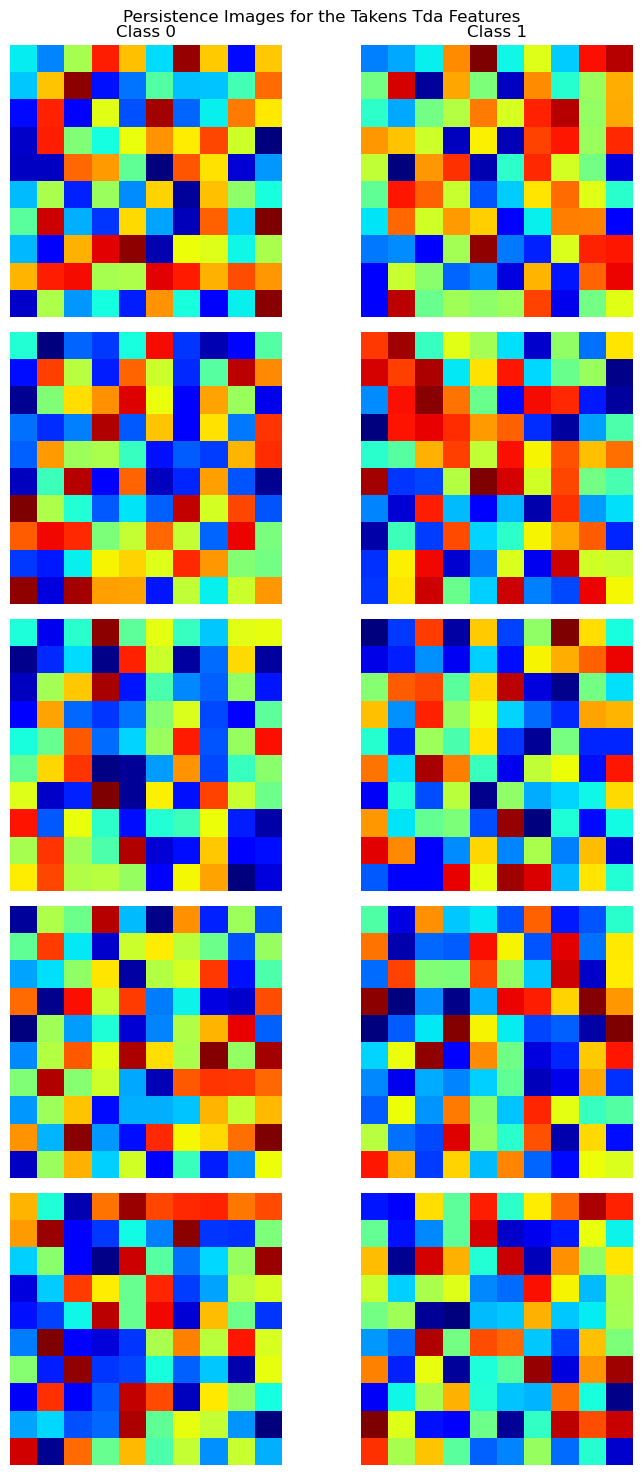

In [16]:
#labels, persistence_images_normalized = get_tda_features_and_labels(df_train)
#plot_persistence_images(labels, persistence_images_normalized, "normalized_data", samples_per_class=5)

# Call NEW TDA feature (PI) generation function ===
# The function feature_engineering.get_tda_features_and_labels needs a major rewrite
# to implement Takens' embedding and PI generation for individual series.

if 'df_train' in locals():
    # from feature_engineering import get_tda_features_takens # This would be your new function
    
    # Define Takens' and PI parameters (should be consistent with diagram computation if reusing,
    # or could be tuned separately for PI generation)
    takens_embedding_dim_pi = 3
    takens_time_delay_pi = 10
    ripser_maxdim_pi = 1
    
    # PI parameters will be defined INSIDE your new get_tda_features_takens function
    # e.g., birth_range, pers_range, pixel_size, weighting_function, etc.
    
    print(f"\nAttempting to generate Persistence Images using Takens' embedding with dim={takens_embedding_dim_pi}, delay={takens_time_delay_pi}...")

    # This is a placeholder for the call to your NEW function.
    # labels_pi_takens, persistence_images_takens = get_tda_features_takens(
    #     df_train,
    #     predictors,
    #     target,
    #     embedding_dim=takens_embedding_dim_pi,
    #     time_delay=takens_time_delay_pi,
    #     max_homology_dim=ripser_maxdim_pi
    #     # Other PI parameters would be handled inside the function
    # )

    # For now, let's simulate a placeholder output
    print("PLACEHOLDER: `get_tda_features_takens` call skipped. Using dummy data for PIs.")
    num_pi_samples = min(100, len(df_train))
    # Assuming 10x10 PIs based on original notebook's local PI imager (0.5 pixel, 0-5 range)
    # Adjust if your new PI parameters are different
    pi_dimension = 10 * 10 
    dummy_pis = np.random.rand(num_pi_samples, pi_dimension)
    # Reshape to 3D for plotting (samples, height, width)
    persistence_images_takens_plot = dummy_pis.reshape(num_pi_samples, 10, 10) 
    labels_pi_takens_plot = df_train['y'].iloc[:num_pi_samples].values

    # print(f"Generated {persistence_images_takens_plot.shape[0]} Takens-based PIs.")

    # === MODIFICATION PLAN for plot_persistence_images ===
    # The visualization.plot_persistence_images function needs to be adapted for 2 classes.
    # (No changes to the call itself if the function is made flexible internally)
    # from visualization import plot_persistence_images # Assuming imported & modified
    
    if 'persistence_images_takens_plot' in locals():
        plot_persistence_images(
            labels_pi_takens_plot, 
            persistence_images_takens_plot, 
            "takens_tda_features", # New name for the plot
            samples_per_class=5,
            # class_labels_map=CLASS_LABELS # Pass if your plot_persistence_images uses it for titles
        )
    else:
        print("Takens-based PIs not available for plotting.")
else:
    print("df_train not available. Skipping PI generation and plotting.")

### Function to plot the persistence diagrams

In [20]:
#plot_persistence_diagrams_from_data(df_train, "raw_normalized_data")

# Call NEW/MODIFIED plot_persistence_diagrams function ===
# The function visualization.plot_persistence_diagrams_from_data
# needs a major rewrite if you want to plot sample diagrams from the new Takens' approach.
# Let's assume you create a new function, e.g., plot_takens_persistence_diagrams.

if 'df_train' in locals():
    # from visualization import plot_takens_persistence_diagrams # Your new plotting function

    print("\nAttempting to plot sample Persistence Diagrams from Takens' embedding...")
    
    # This is a placeholder for the call to your NEW function.
    # The actual function needs to be implemented in visualization.py.
    # It would take df_train, select a few samples from each class,
    # perform Takens + Ripser for those samples, and plot their H0/H1 diagrams.
    # plot_takens_persistence_diagrams(
    #     df_train,
    #     predictors,
    #     target,
    #     class_labels_map=CLASS_LABELS, # Pass the binary class labels
    #     samples_per_class=3,          # Example
    #     embedding_dim=takens_embedding_dim, # Use consistent Takens params
    #     time_delay=takens_time_delay,
    #     max_homology_dim=ripser_maxdim
    # )
    print("PLACEHOLDER: `plot_takens_persistence_diagrams` call skipped as function needs implementation.")
else:
    print("df_train not available. Skipping Takens-based PD plotting.")


Attempting to plot sample Persistence Diagrams from Takens' embedding...
PLACEHOLDER: `plot_takens_persistence_diagrams` call skipped as function needs implementation.


## TRAINING AND HYPERPARAMETER OPTIMIZATION OF DATA WITHOUT NOISE

The next code block is a **setup or configuration step for your entire feature engineering pipeline, especially for the TDA part.**

*   It tells your `FeatureExtractor` *where* to find the already computed diagrams.
*   It tells your `FeatureExtractor` *how* to create Persistence Images from those diagrams (by specifying `pi_params_for_takens`).

If you try to run a Cell that has `run_model_on_features(...)` (or its equivalent) *without* first running this setup block:
*   The `feature_methods` dictionary used by `run_model_on_features` would be created with default parameters (if `get_extractors_methods` in `run_experiments.py` still calls it with no arguments).
*   The `FeatureExtractor` instance wouldn't know about your pre-computed diagrams or your specific PI parameters.
*   Consequently, the TDA feature generation would either fail or not use your pre-computed diagrams and carefully chosen PI settings.

This setup block, should be placed:

1.  **After** you have loaded your main training data (`df_train_full`).
2.  **After** you have successfully run the code that computes and saves `diagrams_takens.joblib` and `labels_takens.joblib`
3.  **Immediately before** the sequence of cells that start calling `run_model_on_features(...)` or the XGBoost specific runners for the *noiseless data analysis*.


In [ ]:
from feature_engineering import get_extractors_methods
import os # if not already imported

# Define paths to your saved diagrams and labels
output_tda_dir = "tda_outputs" # Directory where you saved them
saved_diagrams_path = os.path.join(output_tda_dir, "diagrams_takens.joblib")
saved_labels_path = os.path.join(output_tda_dir, "labels_takens.joblib")

# Define your Persistence Imager parameters (CRITICAL - TUNE THESE)
# These are examples, you MUST determine appropriate ranges and pixel_size
# based on your actual diagrams from Takens' embedding.
pi_params_for_takens = {
    'birth_range': (0.0, 2.0),  # Example: Inspect your diagram birth values
    'pers_range': (0.0, 1.5),   # Example: Inspect your diagram persistence (death-birth) values
    'pixel_size': 0.05,         # Example: This will affect PI resolution (and feature vector length)
    'weight_function': lambda D: D[:, 1] - D[:, 0], # Example: Weight by persistence
    # 'kernel_params': {'sigma': [[0.01, 0.0], [0.0, 0.01]]}, # Example: Gaussian kernel std dev
    'n_jobs': -1 # Use all available CPU cores
}
# Calculate expected PI shape based on ranges and pixel_size for zero_image
# height = int((pi_params_for_takens['pers_range'][1] - pi_params_for_takens['pers_range'][0]) / pi_params_for_takens['pixel_size'])
# width = int((pi_params_for_takens['birth_range'][1] - pi_params_for_takens['birth_range'][0]) / pi_params_for_takens['pixel_size'])
# For PersistenceImager, the image shape is ( (pers_range_max - pers_range_min)/pixel_size, (birth_range_max - birth_range_min)/pixel_size )
# However, the actual output shape of pi_result from pim.transform might be determined by pim.fit() or fixed if ranges are given.
# For now, let's assume a common shape like 20x20 if pixel_size is 0.05 and ranges are around 1.0.
# It's safer to get this from a trial run of the PI.
# For the zero image, a fixed reasonably sized PI shape is needed if a diagram is empty.
# Let's assume for now the PI will be 20x20 (adjust after testing your PI params)
example_pi_shape = (int((pi_params_for_takens['pers_range'][1] - pi_params_for_takens['pers_range'][0]) / pi_params_for_takens['pixel_size']),
                    int((pi_params_for_takens['birth_range'][1] - pi_params_for_takens['birth_range'][0]) / pi_params_for_takens['pixel_size']))


# Get the dictionary of feature extraction methods
feature_methods = get_extractors_methods(
    scale=True, # Or False if your CSV data Z-scoring is sufficient and you don't want StandardScaler
    diagrams_path=saved_diagrams_path,
    labels_path=saved_labels_path,
    pi_params=pi_params_for_takens,
    pi_hom_dim=1, # Use H1 diagrams for PIs
    pi_shape_tuple=example_pi_shape # Pass the expected shape
)

# Now, when run_model_on_features calls feature_methods["TDA"](data_subset),
# it will use the FeatureExtractor instance configured with these paths and PI params.

#### Logistic Regression with different extractors

In [ ]:
run_model_on_features(df_train, "Logistic Regression", run_logistic_regression)

#### RidgeClassifier

In [ ]:
run_model_on_features(df_train, "Ridge Classifier", run_ridge_classifier)

#### SGD Classifier


In [ ]:
run_model_on_features(df_train, "SGD Classifier", run_sgd_classifier)

#### SVC Classifier


In [ ]:
run_model_on_features(df_train, "SVC Classifier", run_svc_classifier)

#### KNN Classifier

In [ ]:
run_model_on_features(df_train, "KNN Classifier", run_knn_classifier)

#### Random Forest

In [ ]:
run_model_on_features(df_train, "Random Forest Classifier", run_random_forest_classifier)

#### MLP Classifier

In [ ]:
run_model_on_features(df_train, "MLP Classifier", run_mlp_classifier)

#### XGBoost Classifier

In [ ]:
run_model_base_dwt_tda_xgboost(df_train)
run_model_fft_xgboost(df_train)

#### CatBoost Classifier

In [ ]:
run_model_on_features(df_train, "CatBoost Classifier", run_catboost_classifier)

## TRAINING AND HYPERPARAMETER OPTIMIZATION OF THE DATA WITH GAUSSIAN NOISE ADDED

In [ ]:
df_viz_gaussian = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]
df_viz_gaussian[feature_cols] = df_viz_gaussian[feature_cols].apply(gaussian_noise, percentage=1)
df_viz_gaussian['y'] = df_viz_gaussian['y'].map(class_labels)
X_viz_gaussian = normalize_data(df_viz_gaussian, predictors)  
y_viz_gaussian, _ =  get_features_and_labels(data)  
plot_class_signals(X_viz_gaussian, y_viz_gaussian)

In [ ]:
df_train_gaussian = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]
df_train_gaussian[feature_cols] = df_train_gaussian[feature_cols].apply(gaussian_noise, percentage=1)
df_train_gaussian[predictors] = normalize_data(df_train_gaussian, predictors)

## Bottleneck distance (h1)

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_gaussian, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")

In [ ]:
class_a = 1
class_b = 4

between_dist = bottleneck_between_class(
    {k: v['H1'] for k, v in diagrams.items()},
    labels,
    class_a,
    class_b
)

print(f"Bottleneck distance between '{CLASS_LABELS[class_a]}' and '{CLASS_LABELS[class_b]}': {between_dist:.4f}")

In [ ]:
plot_persistence_diagrams_from_data(df_train_gaussian, "gaussian_noise_data")

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_gaussian)
plot_persistence_images(labels, persistence_images_noisy, "gaussian noisy data")


#### KNN (Noisy Data)

In [ ]:
run_model_on_features(df_train_gaussian, "KNN Classifier", run_knn_classifier)

#### Random Forest (Noisy Data)

In [ ]:
run_model_on_features(df_train_gaussian, "Random Forest Classifier", run_random_forest_classifier)

#### XGBoost (Noisy Data)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_gaussian)
run_model_fft_xgboost(df_train_gaussian)

## TRAINING AND HYPERPARAMETER OPTIMIZATION OF THE DATA WITH ARTIFACT NOISE ADDED

### Spike noise

In [ ]:
df_viz_spike = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]

for i, col in enumerate(feature_cols):
    artifact_type = 'spike'
    df_viz_spike[col] = artifact_noise(df_viz_spike[col], 
                                   artifact_type=artifact_type,
                                   percentage=0.99)  
df_viz_spike['y'] = df_viz_spike['y'].map(class_labels) 
X_viz_spike = normalize_data(df_viz_spike, predictors)
y_viz_spike, _ =  get_features_and_labels(data)  

In [ ]:
plot_class_signals(X_viz_spike, y_viz_spike)

In [ ]:
df_train_spike = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]

# Add different types of artifacts to different columns
for i, col in enumerate(feature_cols):
    artifact_type = 'spike'
    df_train_spike[col] = artifact_noise(df_train_spike[col], 
                                   artifact_type='spike',
                                   percentage=0.99)  # 99% of points affected

df_train_spike[feature_cols] = normalize_data(df_train_spike, feature_cols)




## Bottleneck Distance (H1)

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_spike, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")


In [ ]:
class_a = 1
class_b = 4

between_dist = bottleneck_between_class(
    {k: v['H1'] for k, v in diagrams.items()},
    labels,
    class_a,
    class_b
)

print(f"Bottleneck distance between '{CLASS_LABELS[class_a]}' and '{CLASS_LABELS[class_b]}': {between_dist:.4f}")


### Visualize the Persistence Images of the Artifact Noise Data

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_spike)
plot_persistence_images(labels, persistence_images_noisy, "artifact_noise_data")


### Visualize the persistence diagrams of the Artifact noise data

In [ ]:
plot_persistence_diagrams_from_data(df_train_spike, "eyeblink_noise_data")

#### KNN (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "KNN Classifier", run_knn_classifier)

#### Random Forest (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "Random Forest Classifier", run_random_forest_classifier)

#### CatBoost (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "CatBoost Classifier", run_catboost_classifier)

#### XGBoost (Artifact Noise Data)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_spike)
run_model_fft_xgboost(df_train_spike)

### Try with eyeblink

In [ ]:
df_viz_eyeblink = data.copy()
feature_cols = [x for x in df_viz_eyeblink.columns if x.startswith('X')]

for i, col in enumerate(feature_cols):
    artifact_type = 'eyeblink'
    df_viz_eyeblink[col] = artifact_noise(df_viz_eyeblink[col], 
                                   artifact_type=artifact_type,
                                   percentage=0.1)  
df_viz_eyeblink['y'] = df_viz_eyeblink['y'].map(class_labels) 
X_viz_eyeblink = normalize_data(df_viz_eyeblink, predictors)
y_viz_eyeblink, _ =  get_features_and_labels(df_viz_eyeblink)  

In [ ]:
df_train_eyeblink = data.copy()
df_train_eyeblink['Unnamed'] = data['Unnamed']  # if needed

feature_cols = [x for x in df_train_eyeblink.columns if x.startswith('X')]

for col in feature_cols:
    df_train_eyeblink[col] = artifact_noise(df_train_eyeblink[col], artifact_type='eyeblink', percentage=0.99)

df_train_eyeblink[feature_cols] = normalize_data(df_train_eyeblink, feature_cols)

## Bottleneck Distance

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_eyeblink, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")

In [ ]:
target_class = 'seizure activity'
within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{target_class}': {within_dist:.4f}")

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_eyeblink)
plot_persistence_images(labels, persistence_images_noisy, "artifact_noise_data")

In [ ]:
plot_persistence_diagrams_from_data(df_train_eyeblink, "eyeblink_noise_data")

In [ ]:
run_model_on_features(df_train_eyeblink, "KNN Classifier", run_knn_classifier)

In [ ]:
run_model_on_features(df_train_eyeblink, "Random Forest Classifier", run_random_forest_classifier)

In [ ]:
run_model_on_features(df_train_eyeblink, "CatBoost Classifier", run_catboost_classifier)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_eyeblink )
run_model_fft_xgboost(df_train_eyeblink )

## Show Results

### Full Table of Results

In [ ]:
from metrics import load_and_group_metrics, print_metrics_summary, print_model_deltas, print_model_deltas_noisy2
metrics = load_and_group_metrics("metrics")

for ftype, df in metrics.items():
    print(f"\n=== {ftype} Features Metrics Summary ===")
    print(df.to_string())


In [ ]:
print_metrics_summary("metrics")

In [ ]:
models = ['CatBoost', 'KNN', 'Logistic Regression', 'MLP', 'Random Forest', 'Ridge Classifier', 'SGD Classifier', 'SVC', 'XGBoost']
for model in models:
    print_model_deltas(model)


In [ ]:
models = ['CatBoost', 'KNN', 'Logistic Regression', 'MLP', 'Random Forest', 'Ridge Classifier', 'SGD Classifier', 'SVC', 'XGBoost']
for model in models:
    print_model_deltas(model)

In [ ]:
#for model in models:
 #   plot_model_absolute_bars(model)

In [ ]:
models = [ 'CatBoost', 'KNN', 'Random Forest', 'XGBoost']
for model in models:
    result = print_model_deltas_noisy2(model)
    result.to_csv(f"metrics/{model}_deltas_noisy.csv", index=False)